In [1]:
import os
os.environ['R_HOME'] = '/usr/lib/R'
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from anndata import AnnData
import scanpy as sc
sc.set_figure_params(figsize=(8,8))
import scFates as scf
import palantir
%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
adata=sc.read("adata_tree_auc.h5ad")

In [7]:
adata.uns["graph"]=adata.uns["tree"]

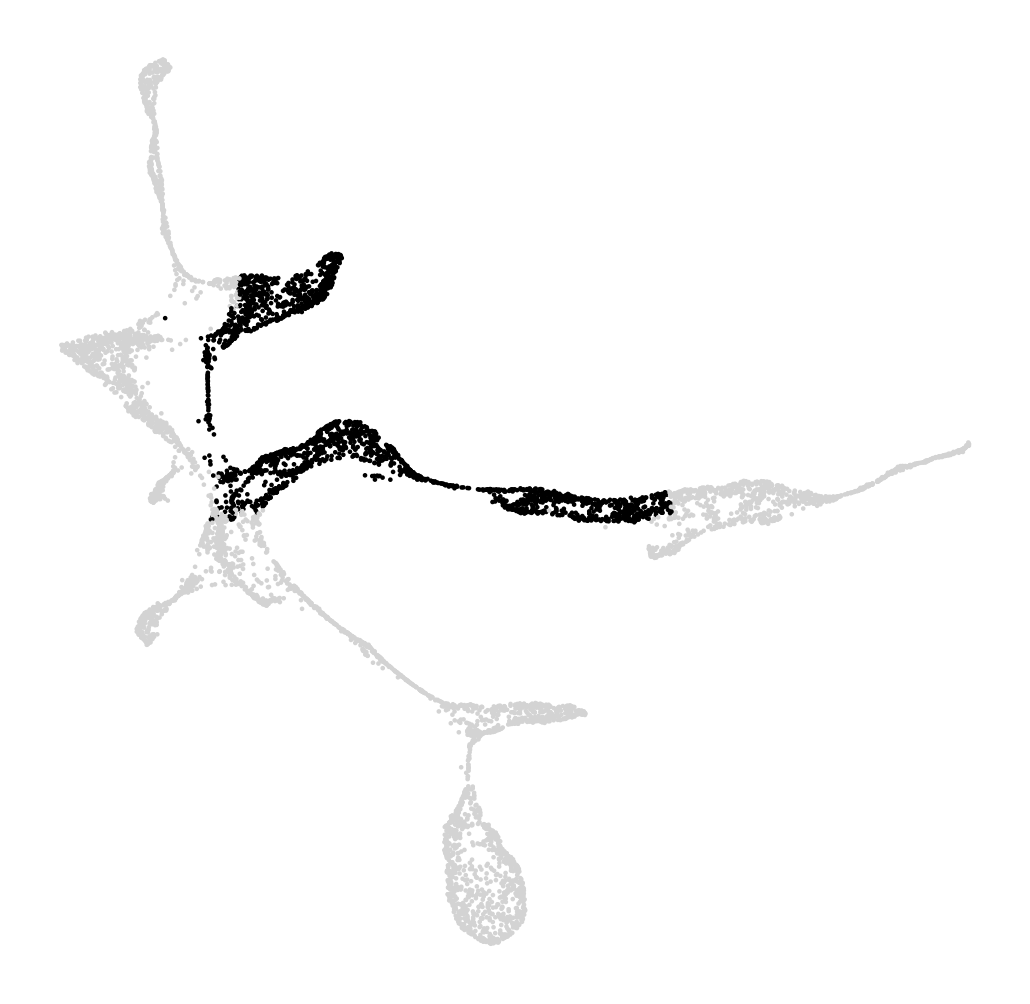

In [11]:
sc.set_figure_params(figsize=(8,8),dpi_save=600)
path=scf.tools.getpath(adata,root_milestone="eptNCC",milestones=["imSC"])
path=path[~path.index.duplicated(keep='first')]
adata.obs["sel"]=adata.obs_names.isin(path.index)
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-eptNCC->imSC_traj_sel.png")

In [3]:
cell_sel=scf.tl.getpath(adata,root_milestone="eptNCC",milestones=["imSC"]).index

auc=pd.read_csv("scenic/output/auc_mtx_mm10.csv",index_col=0)
dm_res = palantir.utils.run_diffusion_maps(auc.loc[cell_sel,:],knn=100)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

Determing nearest neighbor graph...


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


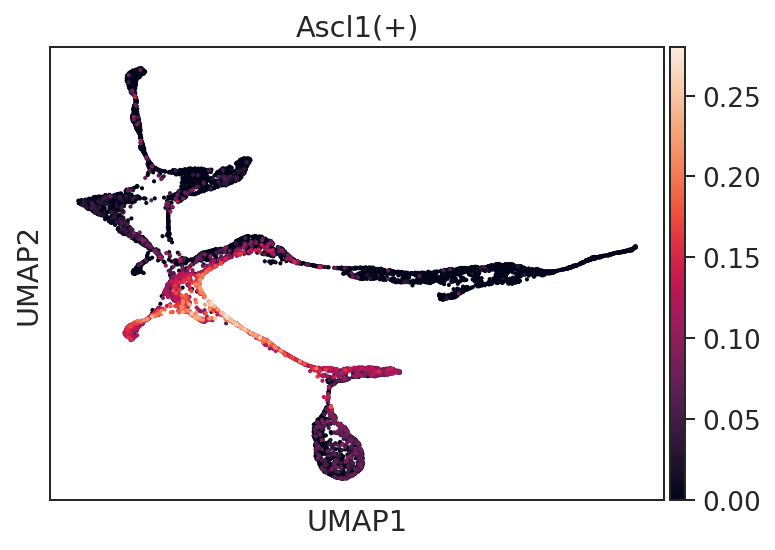

In [4]:
sc.pl.umap(adata,color="Ascl1(+)")

inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.2, lambda = 1000
    fitting:  14%|█▍        | 7/50 [00:00<00:04,  9.79it/s]

Trying to set attribute `.uns` of view, copying.



    converged
    finished (0:00:00) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


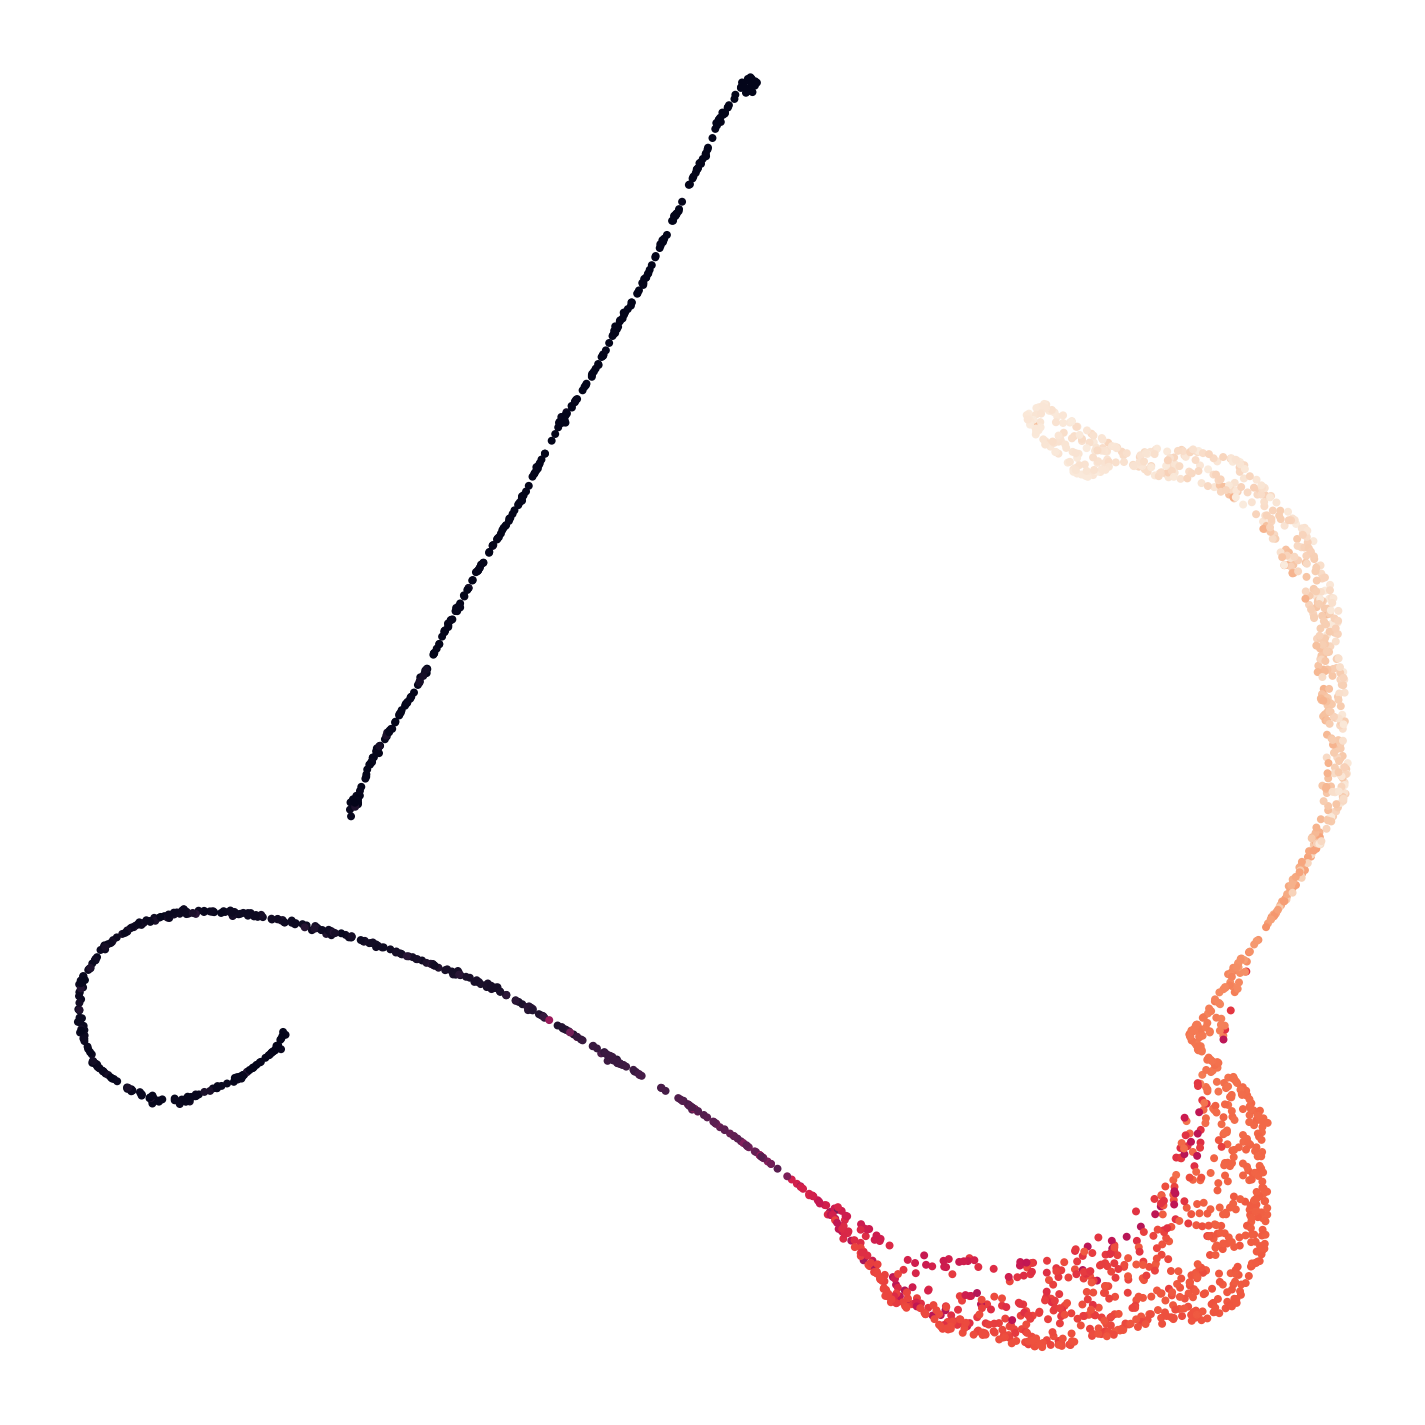

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


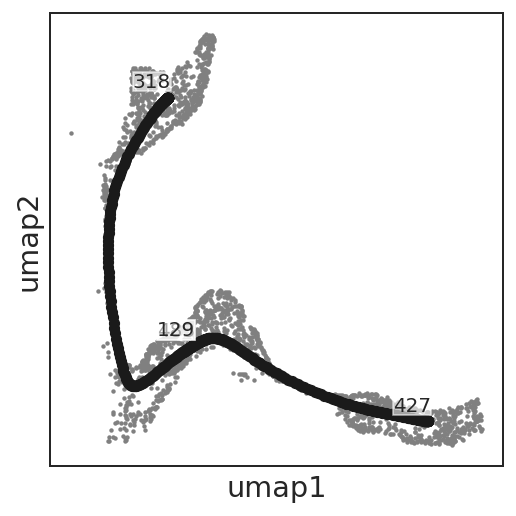

In [5]:
from cuml.manifold import UMAP
umap = UMAP(n_components = 2,n_neighbors=150,min_dist=.4,n_epochs=2000)
emb = umap.fit_transform(ms_data.values)
plt.figure(figsize=(10,10))
plt.scatter(emb[:,0],emb[:,1],c=adata.obs.t[ms_data.index],s=10)
plt.axis("off")
plt.tight_layout()

adata=adata.copy()[ms_data.index,]
#adata.obsm["X_umap"]=emb
scf.tl.tree(adata,Nodes=500,ppt_err_cut=0.01,
            use_rep="diffusion",ppt_sigma = 0.2,ppt_lambda=1000,
            method="ppt",device="gpu",plot=False,seed=1)
scf.pl.tree(adata,basis="umap")

In [6]:
scf.tl.cleanup(adata,minbranchlength=10)

    tree cleaned --> removed 3 principal points


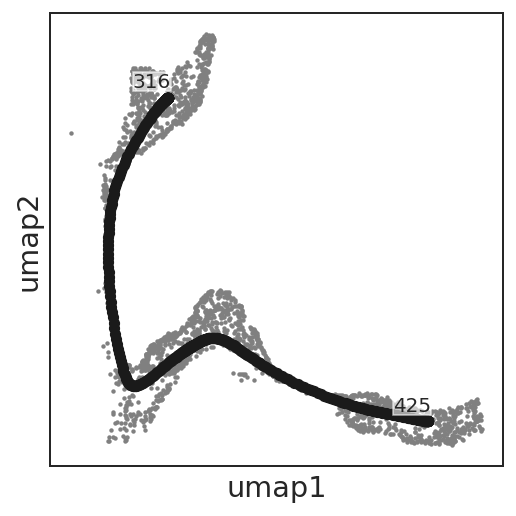

In [7]:
scf.pl.tree(adata,basis="umap")

In [8]:
scf.tl.root(adata,root=316)
scf.tl.pseudotime(adata)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:02) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


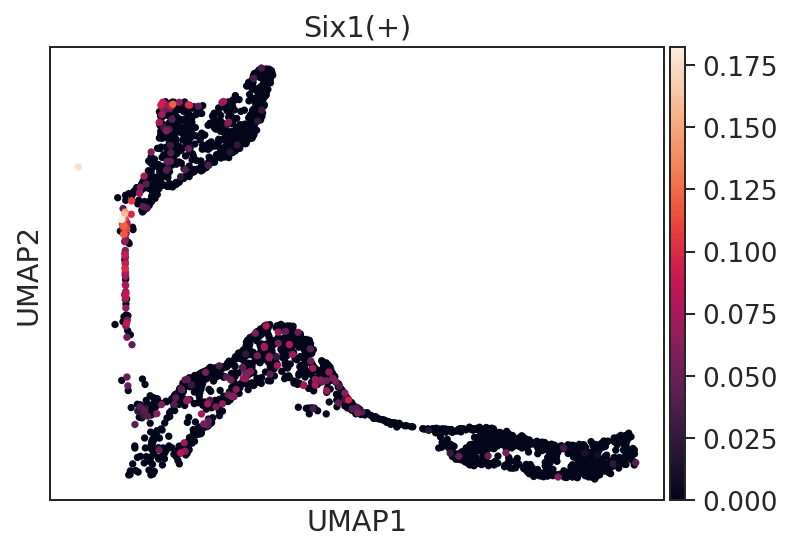

In [9]:
sc.pl.umap(adata,color="Six1(+)")

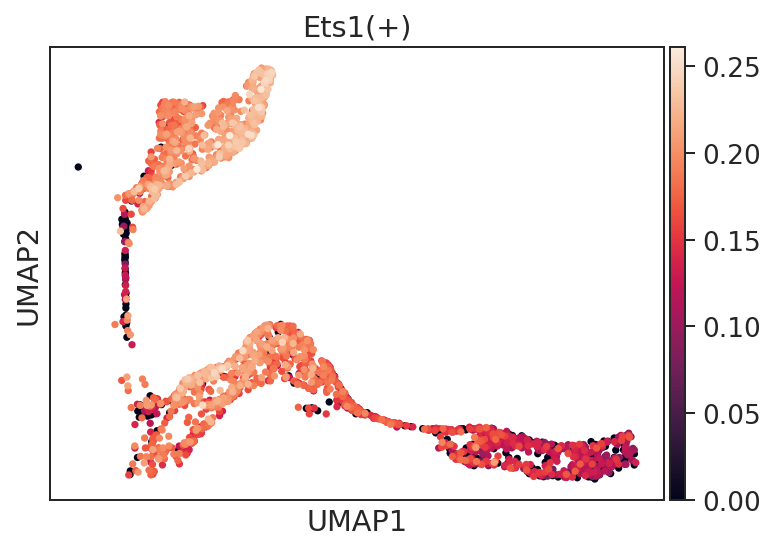

In [10]:
sc.pl.umap(adata,color="Ets1(+)")

In [11]:
scf.tl.refine_pseudotime(adata,ms_data="diffusion")

refining pseudotime using palantir on each segment of the tree
  0%|          | 0/1 [00:00<?, ?it/s]Sampling and flocking waypoints...
Time for determining waypoints: 0.004641401767730713 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.3816665728886922 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...
100%|██████████| 1/1 [00:36<00:00, 36.35s/it]
    finished (0:00:36) --> updated
    't' with palantir pseudotime values (adata.obs)
added
    't_old', previous pseudotime data (adata.obs)


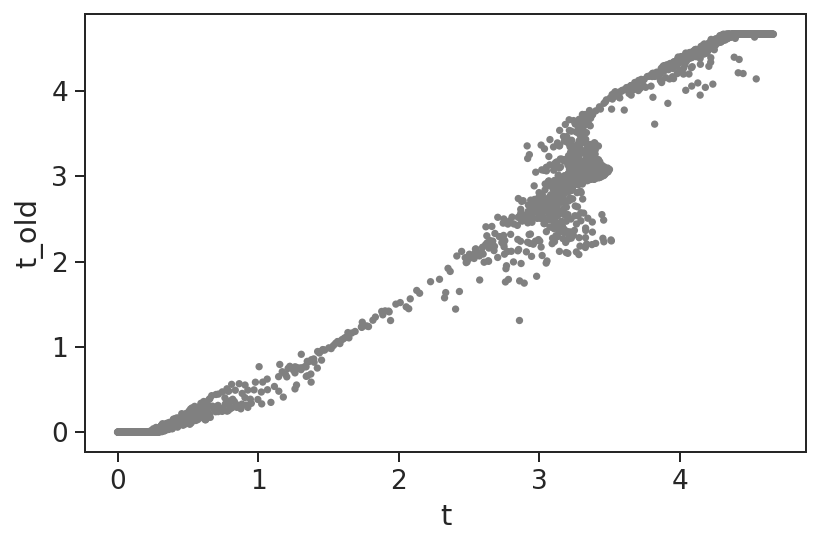

In [12]:
sc.pl.scatter(adata,x="t",y="t_old")

test features for association with the tree
    mapping 0: 100%|██████████| 674/674 [01:15<00:00,  8.96it/s]
    found 192 significant features (0:01:20) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/stat_assoc_list', list of fitted features on the tree for all mappings (adata.uns)


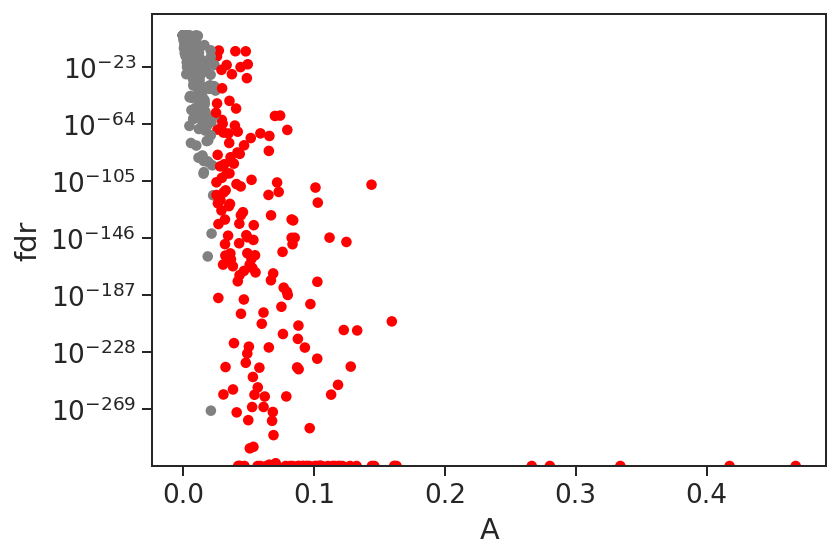

In [13]:
scf.tl.test_association(adata,n_jobs=50,A_cut=.025)
scf.pl.test_association(adata)

In [14]:
scf.tl.fit(adata,n_jobs=50)

fit features associated with the tree
    mapping 0: 100%|██████████| 192/192 [00:01<00:00, 174.40it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:02) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


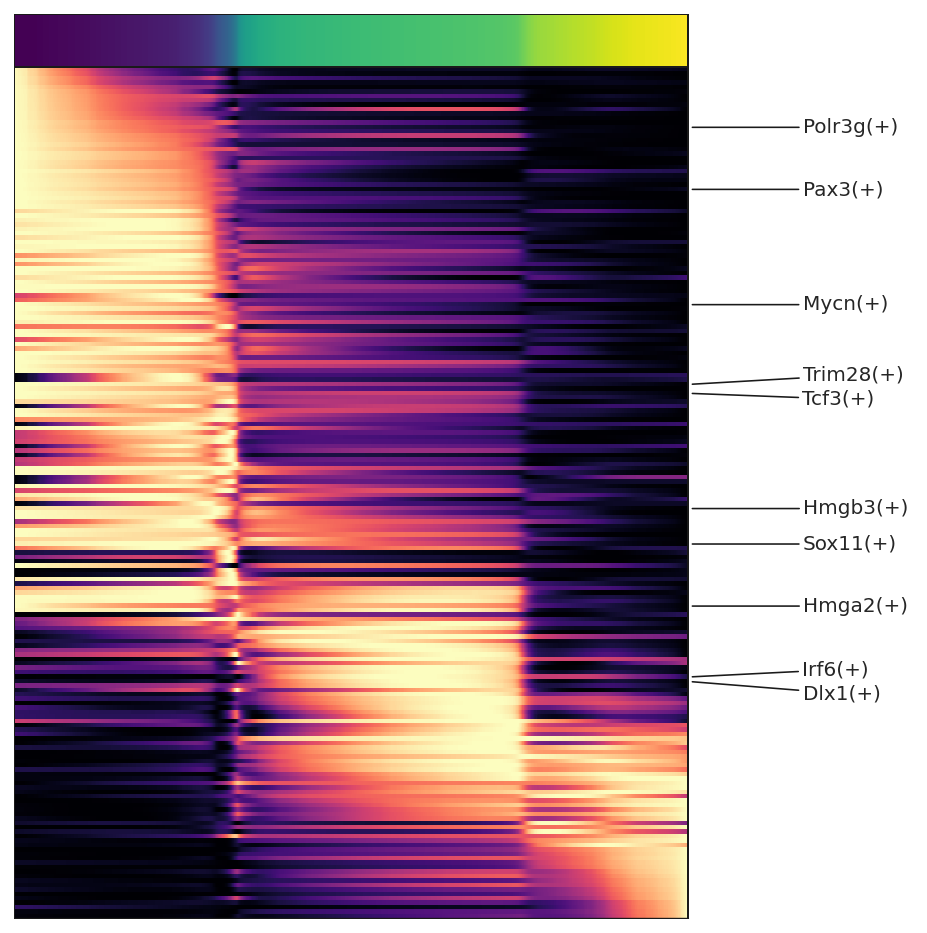

In [15]:
scf.pl.trends(adata,show_milsetones=False,colormap="magma",filter_complex=False)

In [16]:
scf.tl.cluster(adata,knn=15,device="gpu",metric="correlation")

    clustering using grapheno
Finding 15 nearest neighbors using correlation metric and brute algorithm...
Neighbors computed in 0.9718551635742188 seconds...
Computing Jaccard similarity...
jaccard graph constructed in 0.008293867111206055 seconds...
Running Louvain modularity optimization...
grapheno completed in 1.0670592784881592 seconds...
Communities detected: 6
Modularity: 0.6749306321144104
    finished (0:00:08) --> added
    'fit_clusters', cluster assignments for features (adata.var)


In [20]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm, colors

tab_10 = list(map(colors.to_hex, cm.tab10.colors))

tabs=list(map(lambda t: LinearSegmentedColormap.from_list(name="tab",colors=["white",t]),tab_10))

dct_cmap=dict(zip(adata.var.fit_clusters.unique(),tabs))
dct_col=dict(zip(adata.var.fit_clusters.unique(),tab_10))

In [22]:
adata=adata[:,adata.var.fit_clusters!=-1]


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


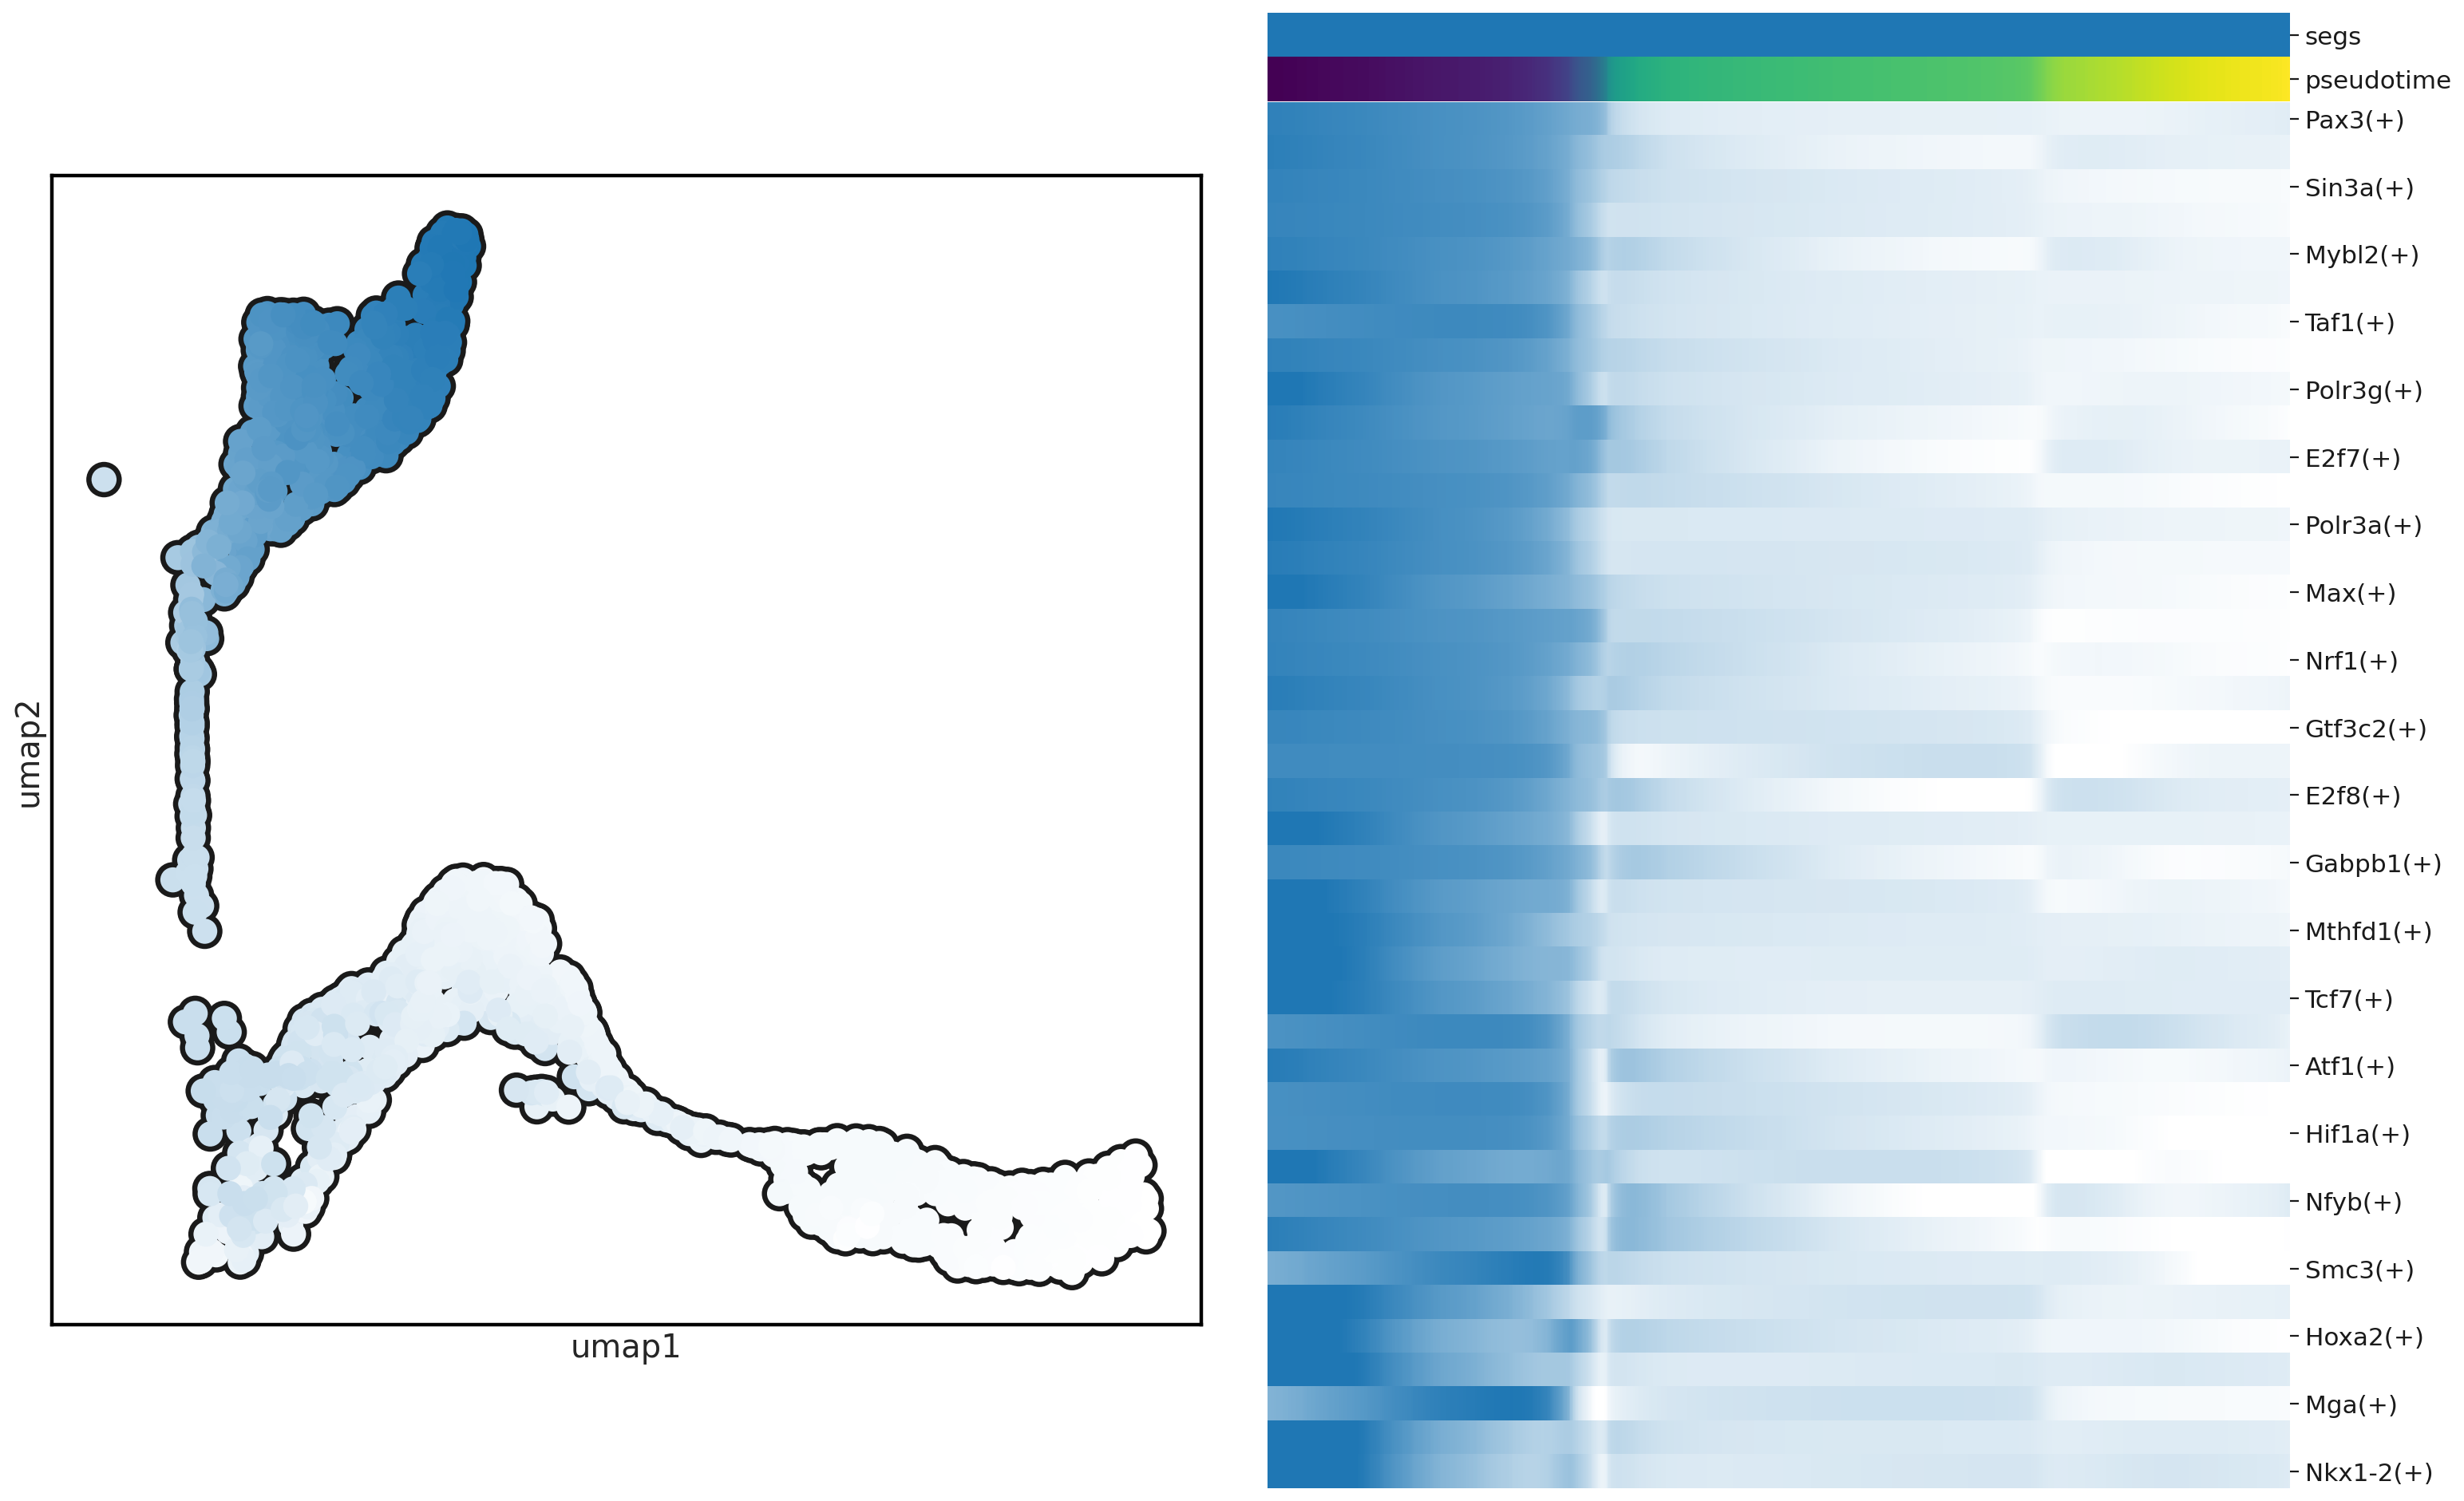

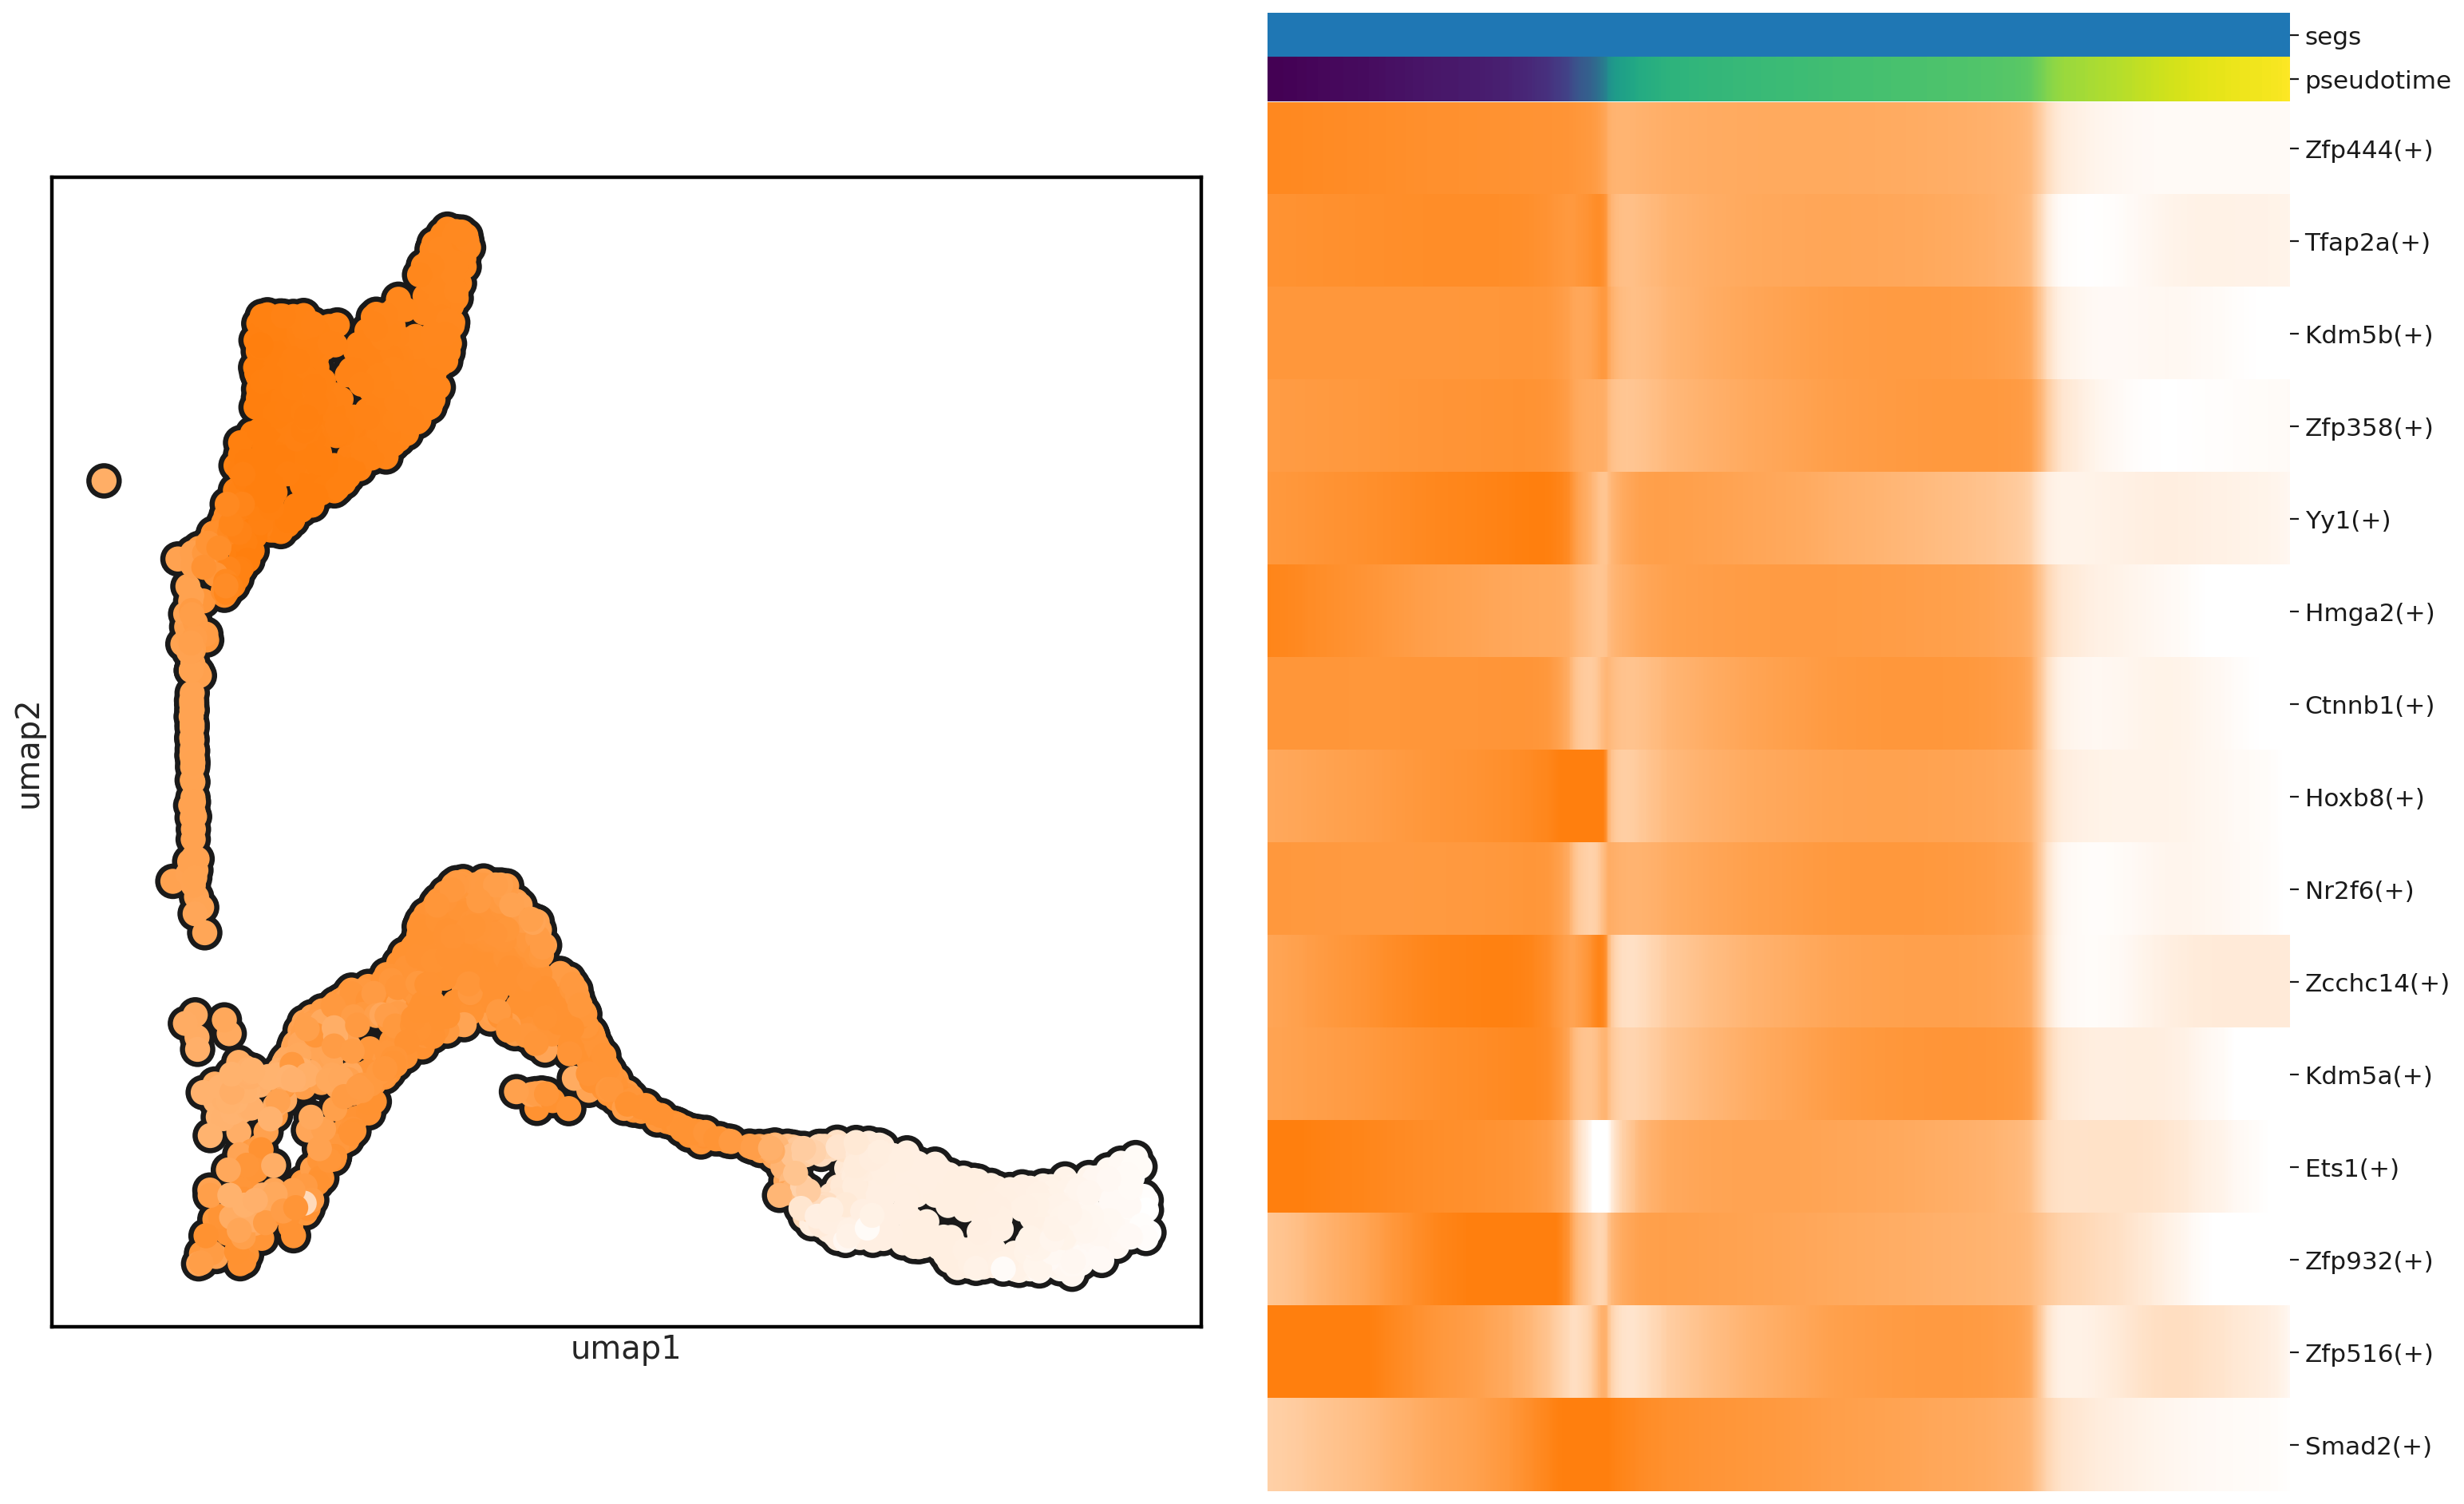

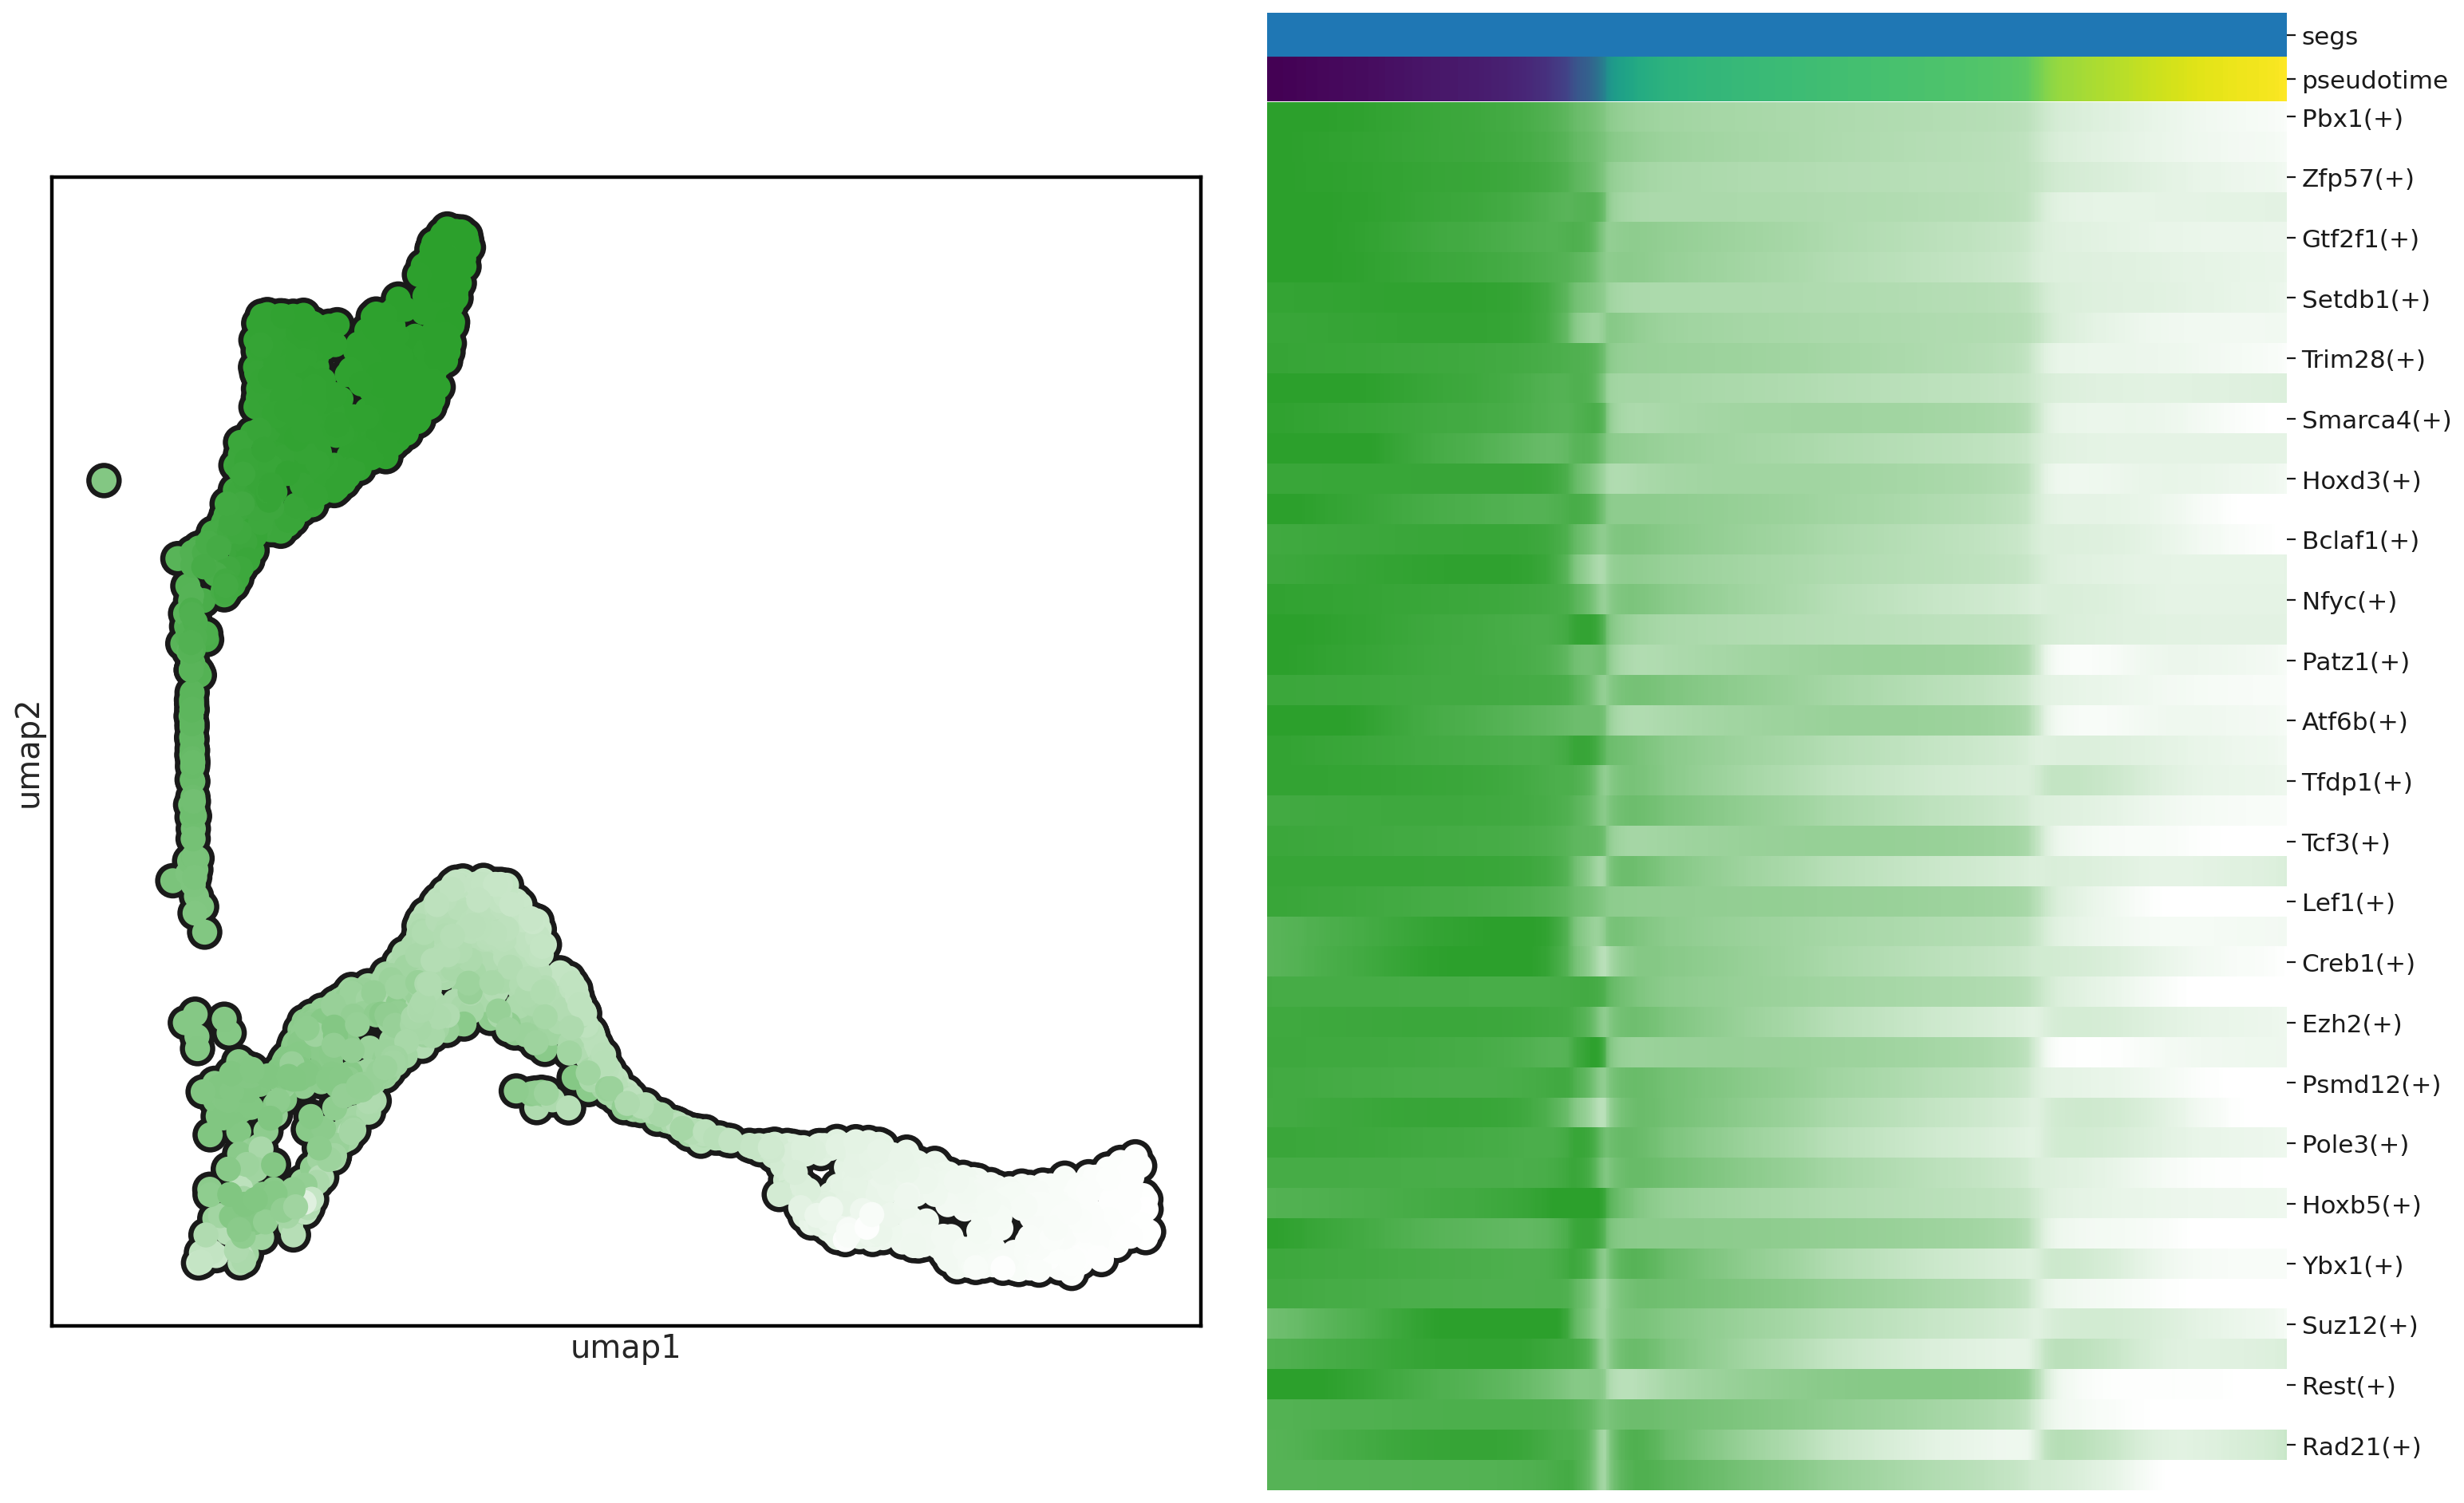

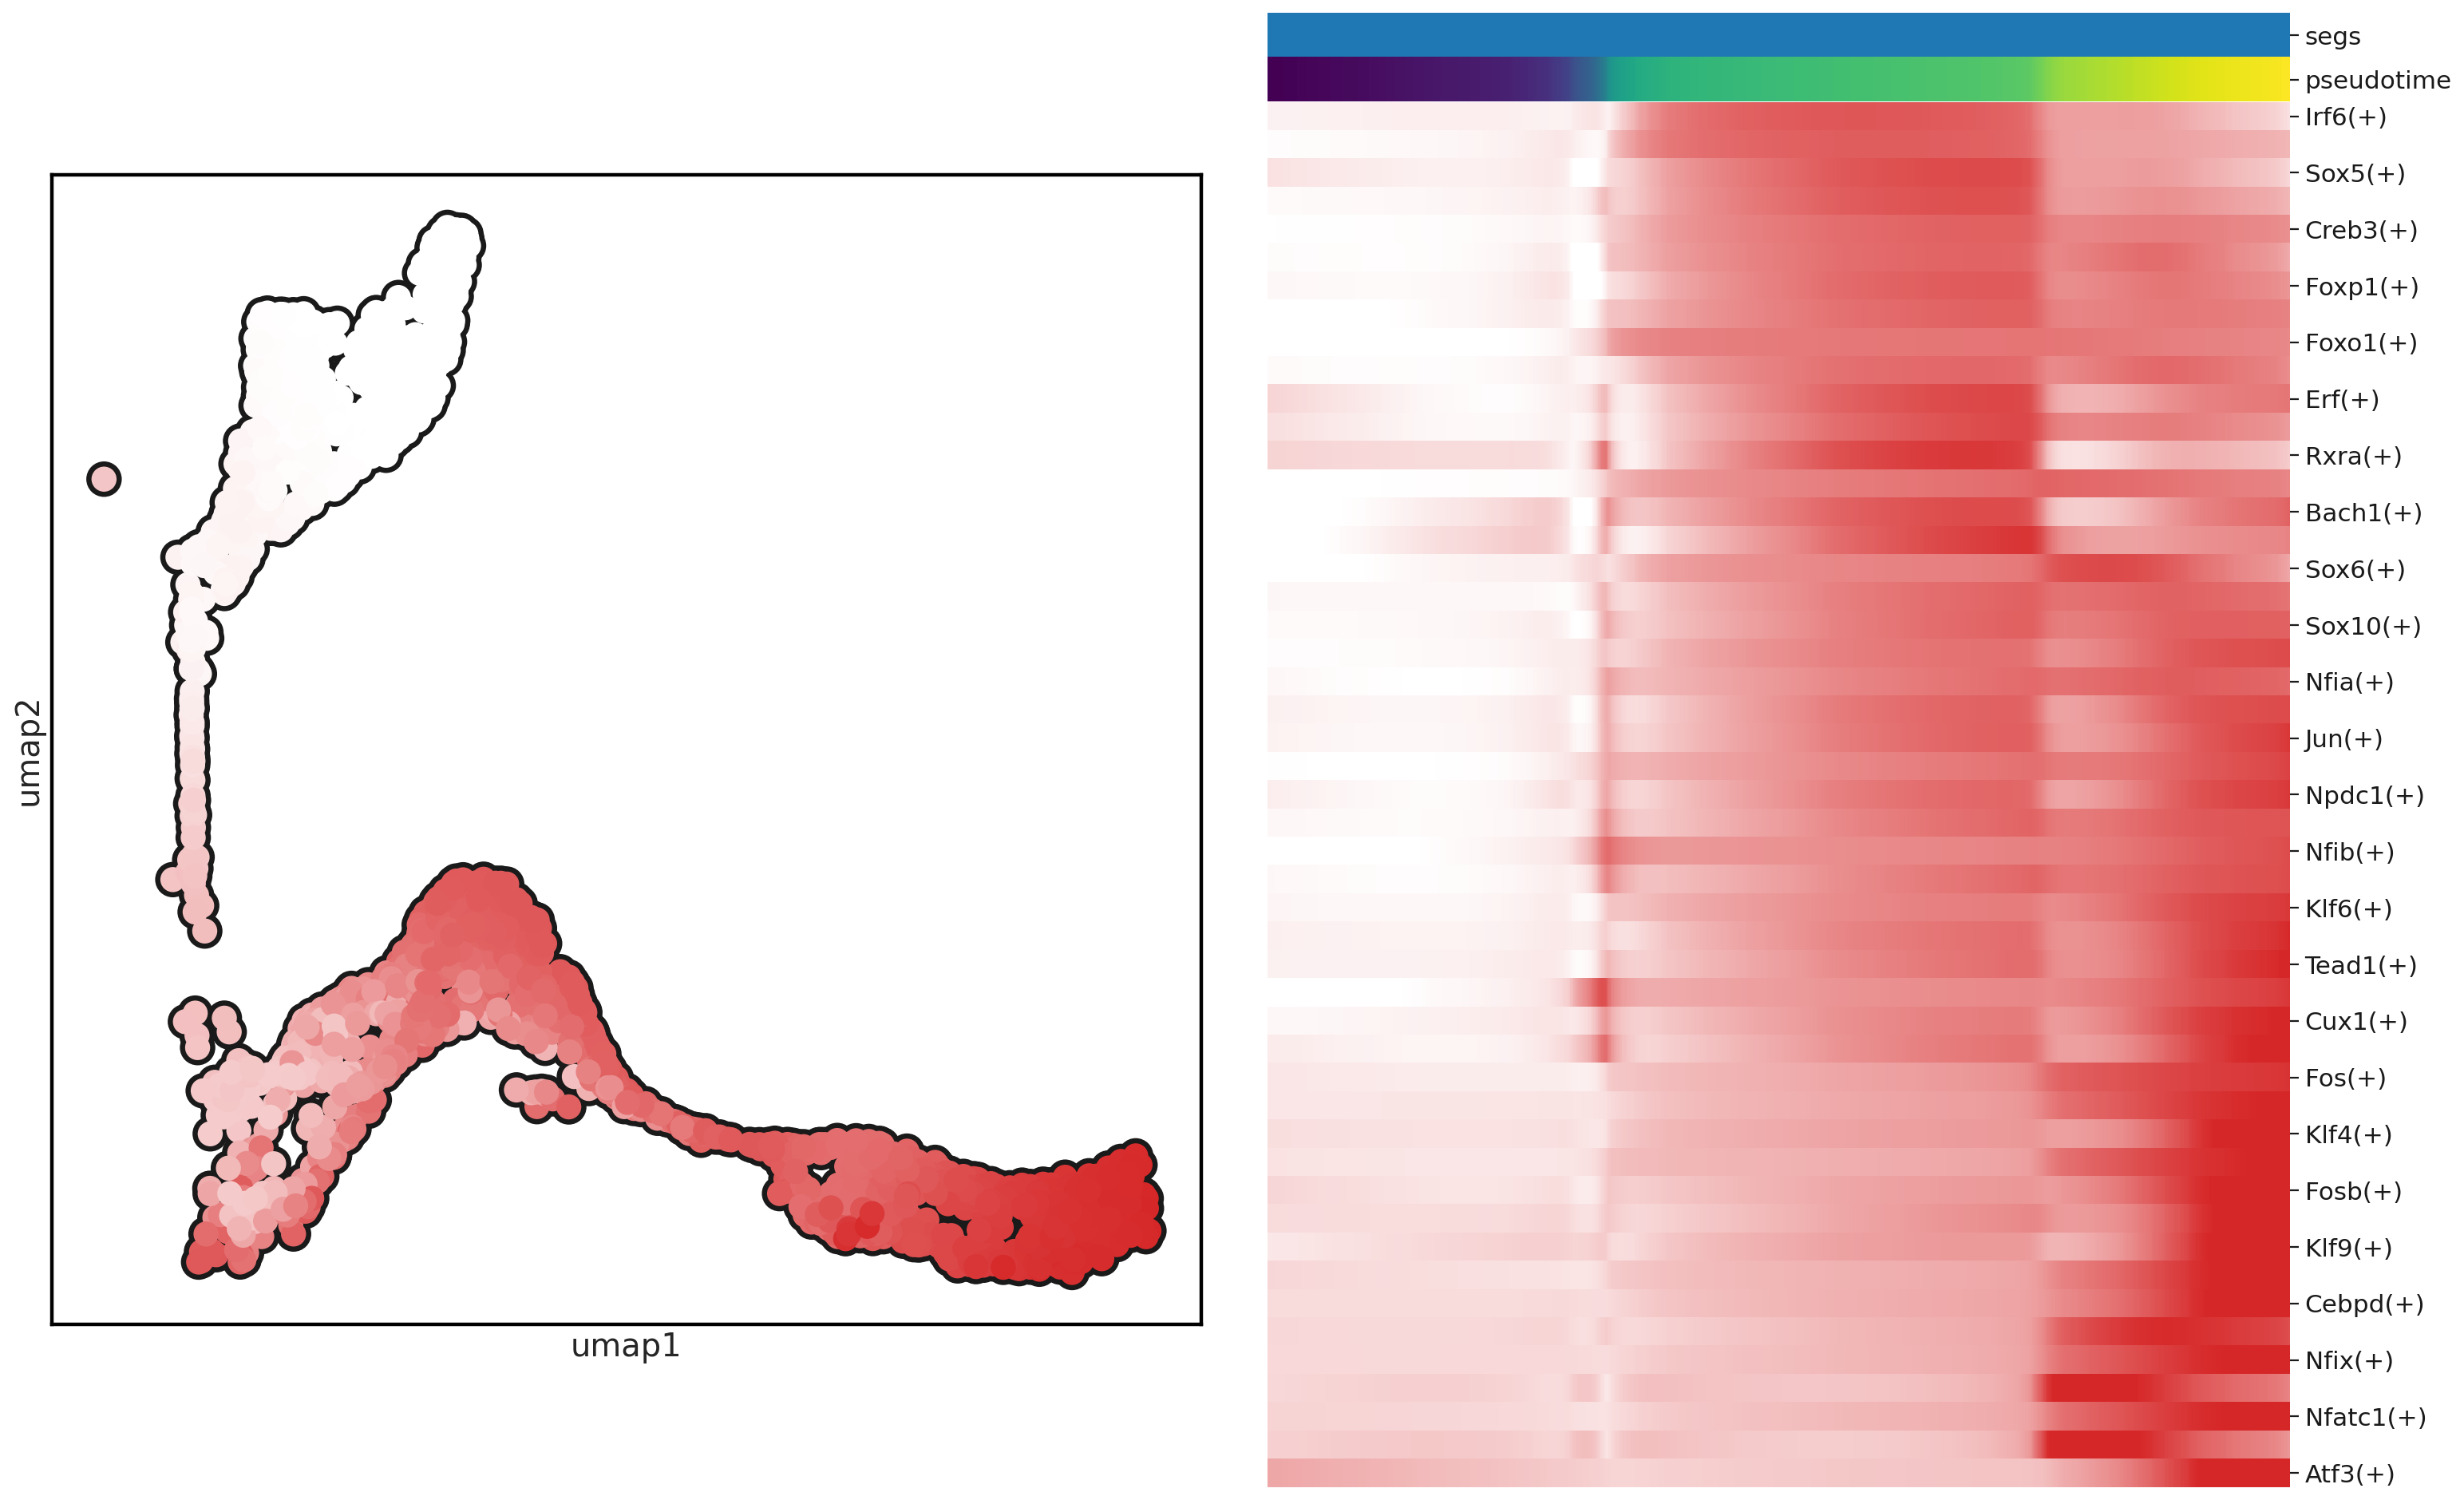

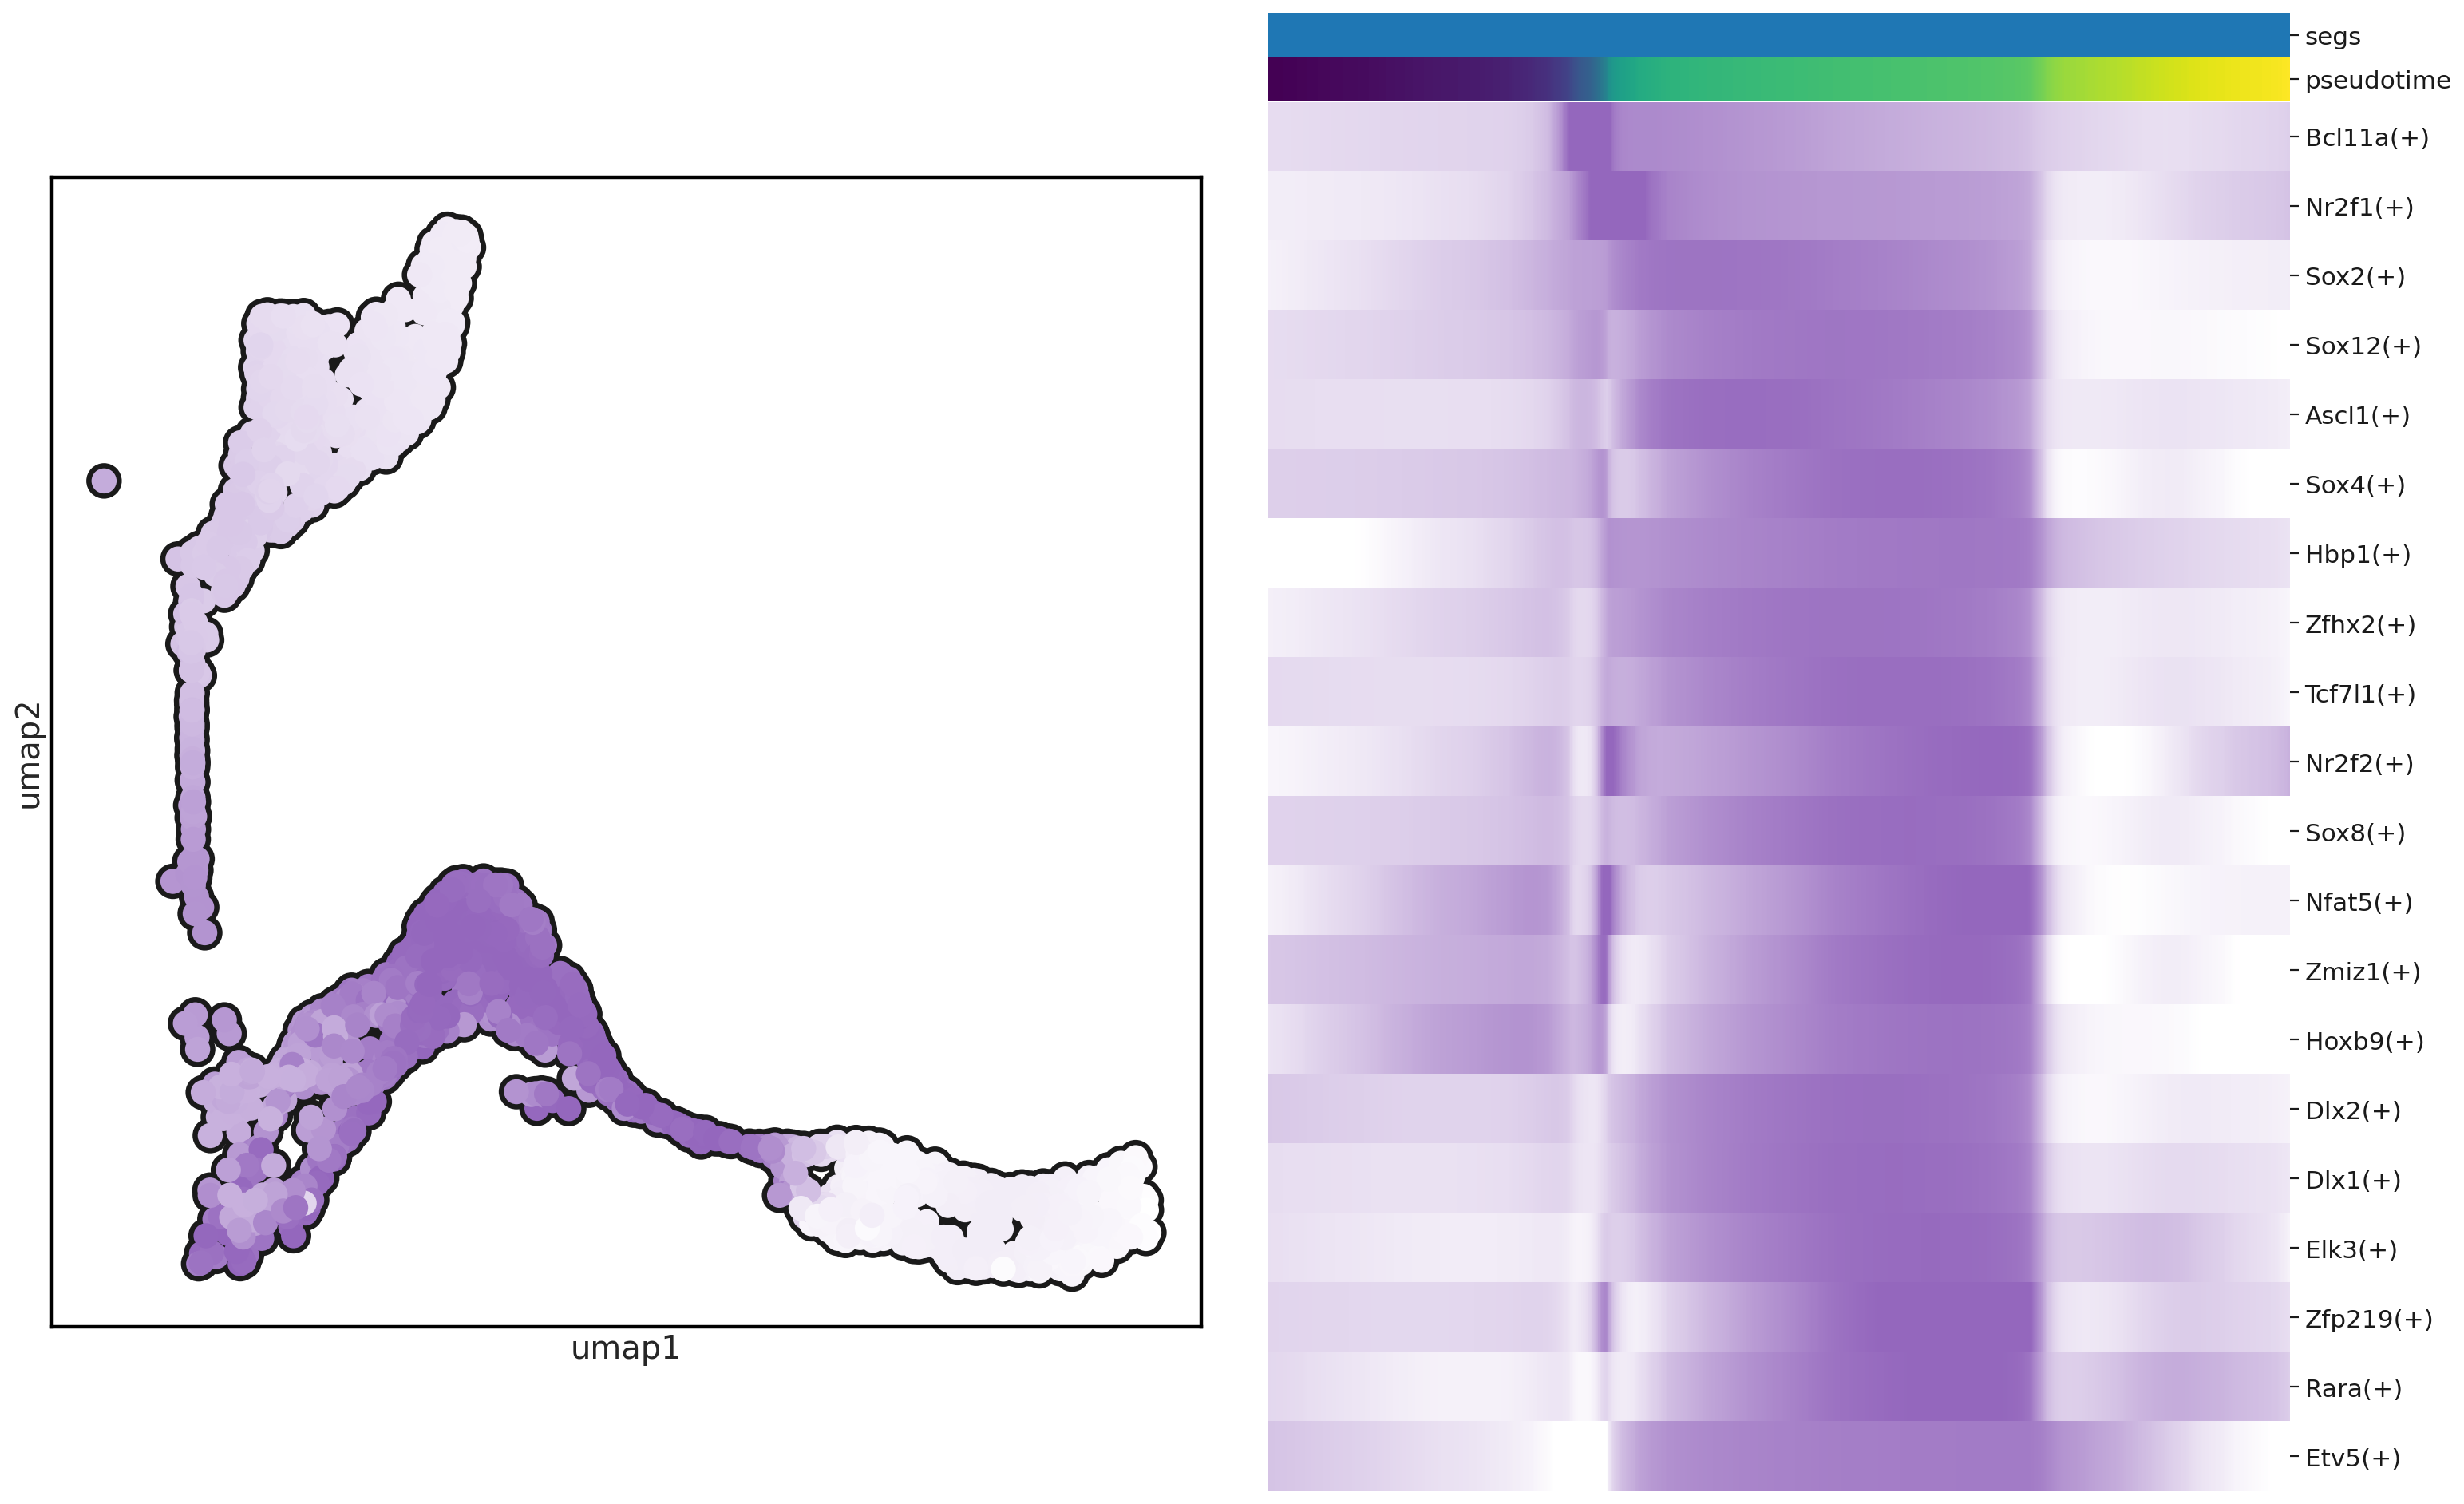

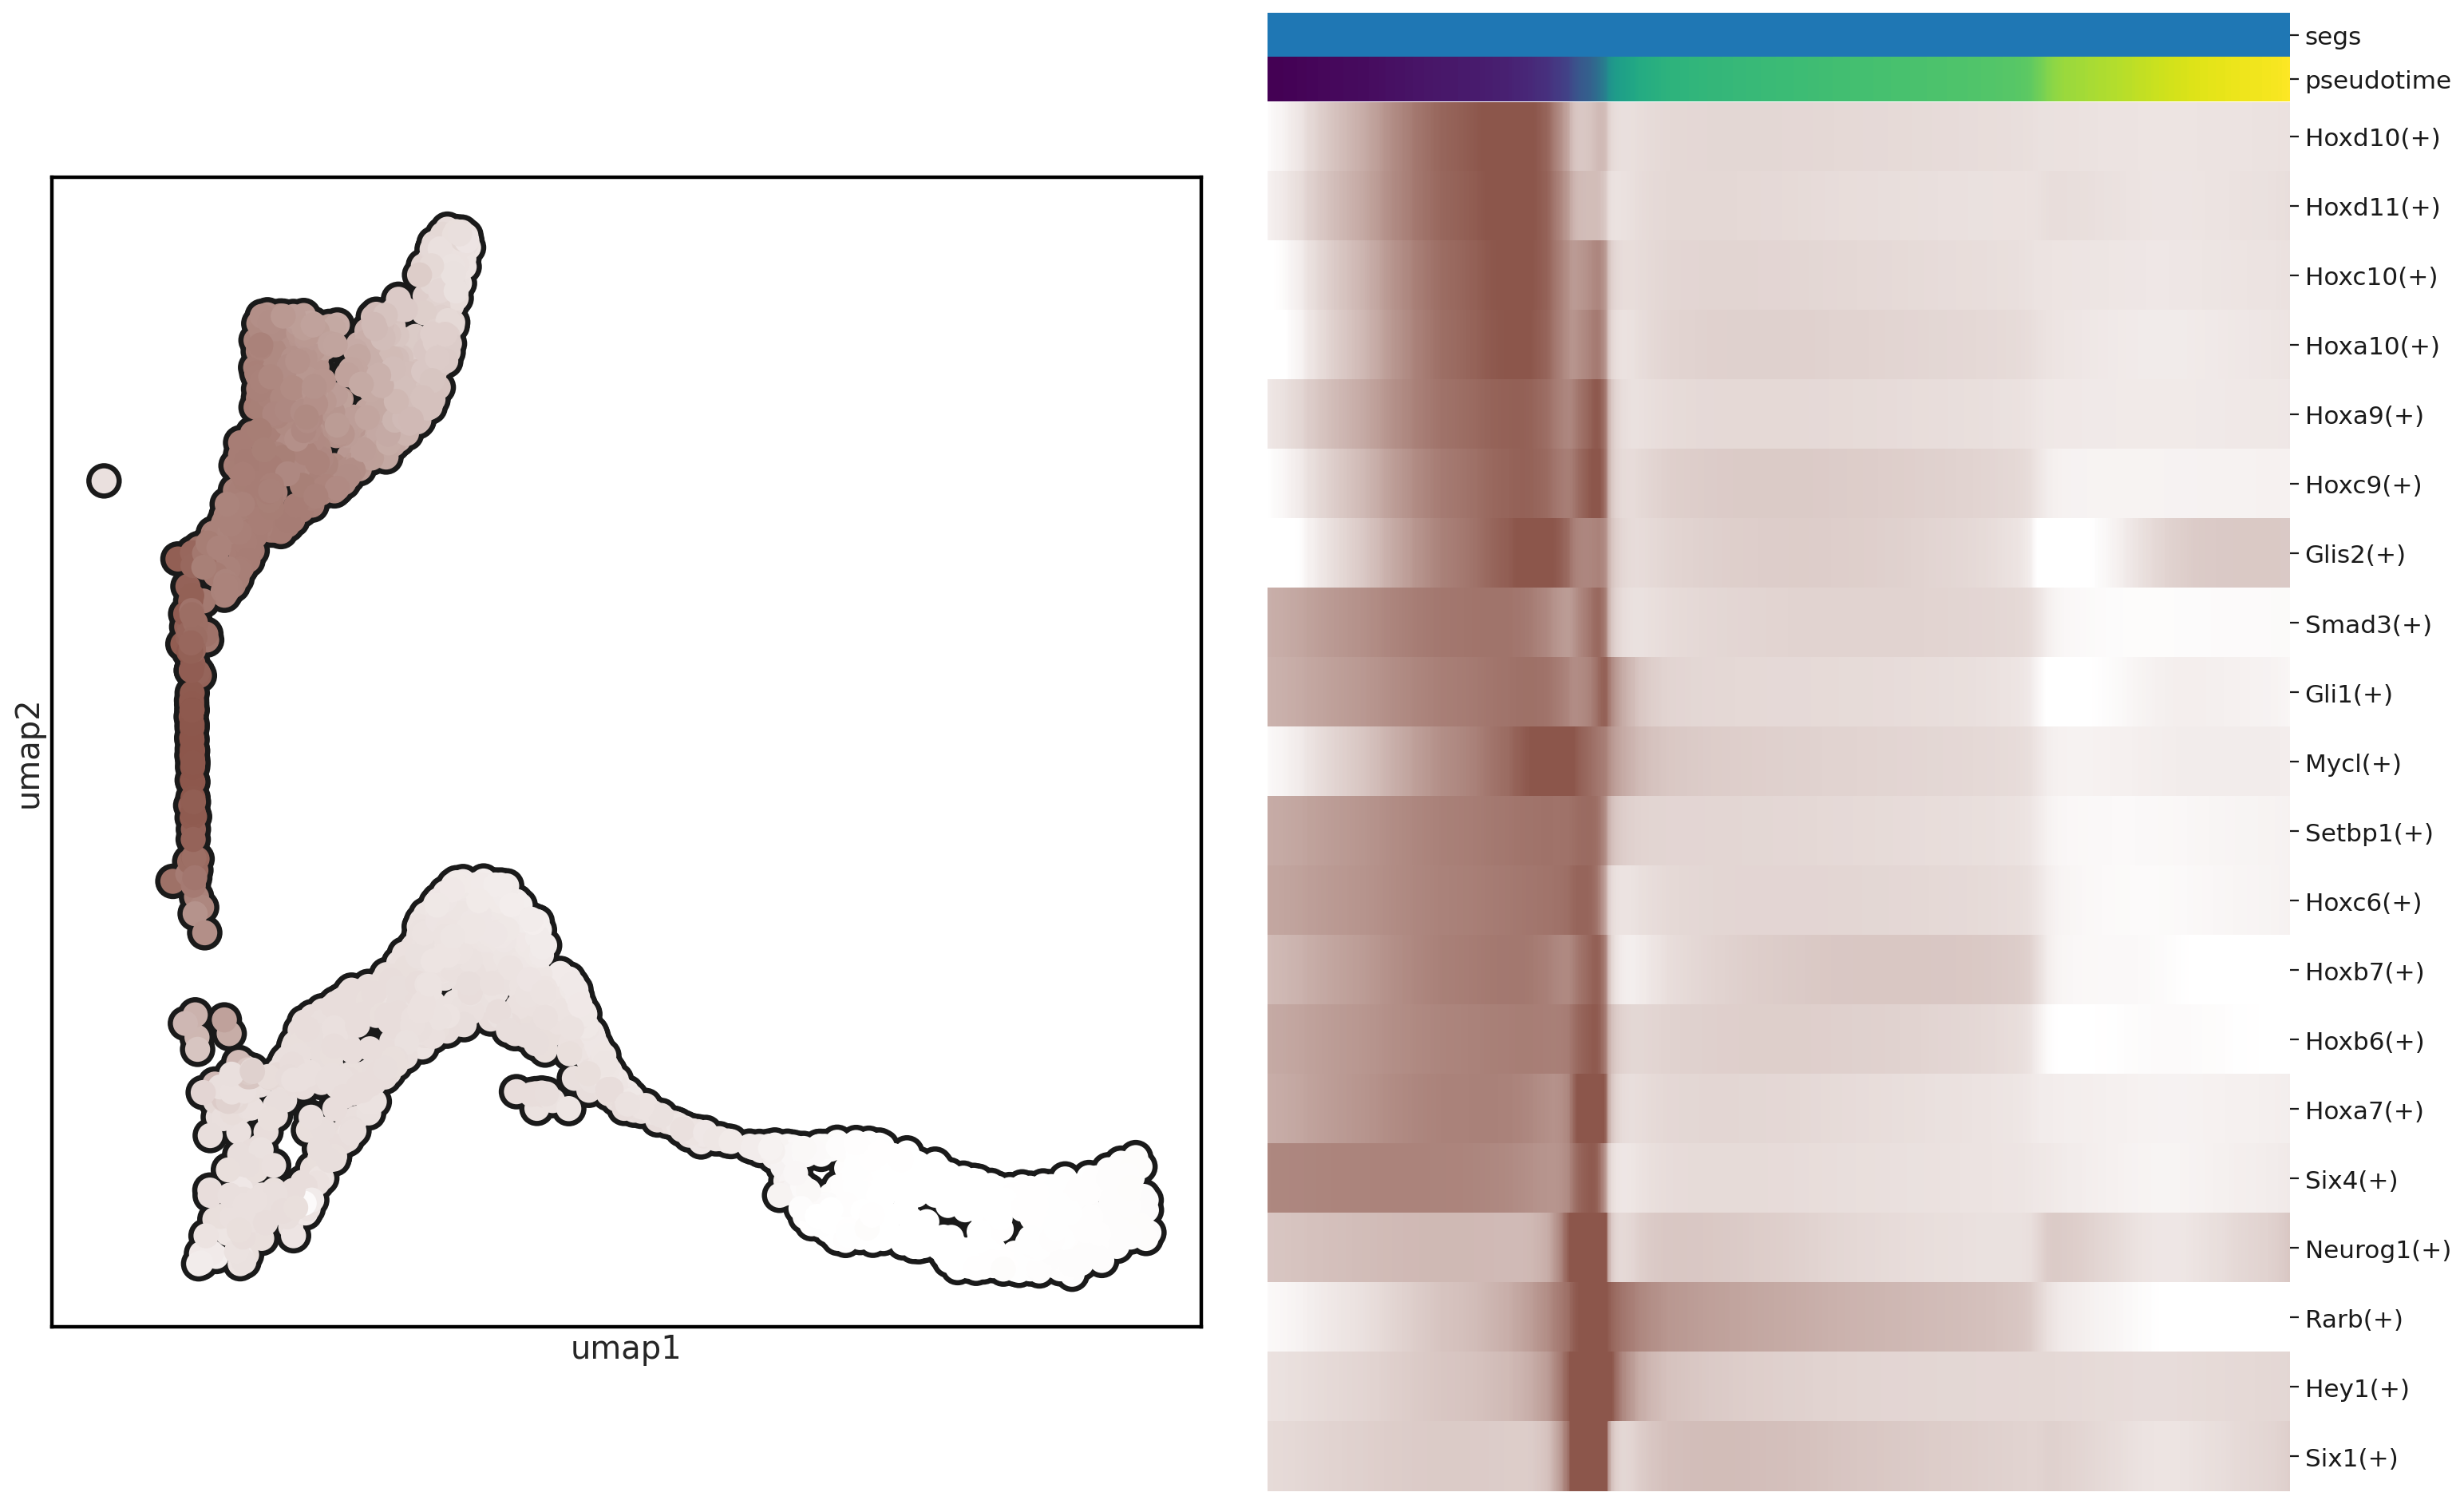

In [53]:
for c in adata.var.fit_clusters.unique():
    scf.pl.cluster(adata,clu=c,colormap=dct_cmap[c],cell_size=200,highlight=True,
                  save="_eptNCC->imSC_"+str(c)+".png",
                  save_genes="eptNCC->imSC_"+str(c)+".txt")

In [24]:
adata.write_h5ad("adata_eptNCC->imSC.h5ad")

In [44]:
import scanpy as sc
adata=sc.read("adata_eptNCC->imSC.h5ad")

In [45]:
import seaborn as sns

In [46]:
fitted = pd.DataFrame(adata.layers["fitted"],index=adata.obs_names,columns=adata.var_names).T.copy(deep=True)
g = adata.obs.groupby('seg')
seg_order=g.apply(lambda x: np.mean(x.t)).sort_values().index.tolist()
cell_order=np.concatenate(list(map(lambda x: adata.obs.t[adata.obs.seg==x].sort_values().index,seg_order)))
fitted=fitted.loc[:,cell_order]
#fitted=fitted.apply(lambda x: (x-x.mean())/x.std(),axis=1)

fitted=fitted.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=1)

In [52]:
adata.var.fit_clusters=adata.var.fit_clusters.astype('category').cat.reorder_categories([2, 1, 3, 5, 4, 0])

In [53]:
adata.var.fit_clusters.sort_values()

Pax3(+)     2
Sin3a(+)    2
Tcf12(+)    2
E2f1(+)     2
Mybl2(+)    2
           ..
Jun(+)      0
Klf4(+)     0
Creb3(+)    0
Nfia(+)     0
Klf9(+)     0
Name: fit_clusters, Length: 191, dtype: category
Categories (6, int64): [2, 1, 3, 5, 4, 0]

In [54]:
fitted=fitted.loc[adata.var.fit_clusters.sort_values().index]

In [60]:
pst=adata.obs.t[fitted.columns]/max(adata.obs.t[fitted.columns])

In [63]:
to_hex()

<function matplotlib.colors.to_hex(c, keep_alpha=False)>

In [55]:
rowcol=[dct_col[c] for c in adata.var.fit_clusters[fitted.index].values]

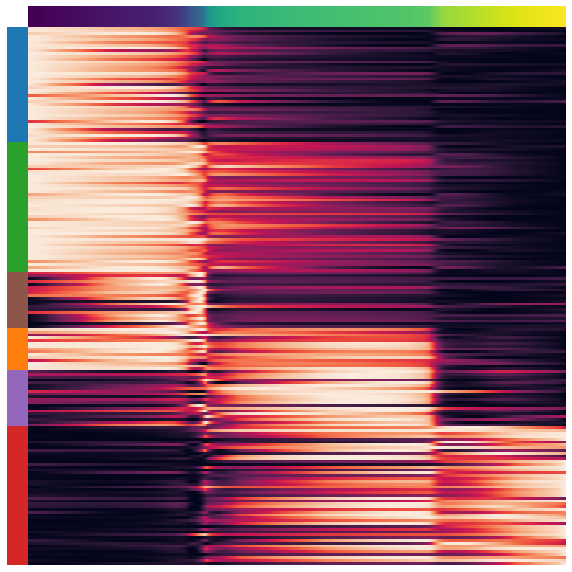

In [66]:
g=sns.clustermap(fitted, row_cluster=False, col_cluster=False,
                 row_colors=rowcol,col_colors=[to_hex(c) for c in cm.viridis(pst)],
                 xticklabels=False,yticklabels=False)
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

In [3]:
fitted=pd.DataFrame(adata.layers["fitted"],index=adata.obs_names,columns=adata.var_names)
fitted=fitted.apply(lambda x: (x-x.mean())/x.std(),axis=0)
df_reg=pd.concat(list(map(lambda c: fitted.loc[adata.obs.t.sort_values().index,adata.var.fit_clusters==c].mean(axis=1),adata.var.fit_clusters.unique())),
          keys=adata.var.fit_clusters.unique()).reset_index()
df_reg.columns=["cluster","cell","activity"]
for c in df_reg.cluster.unique():
    df_reg.loc[df_reg.cluster==c,'activity']=(df_reg.loc[df_reg.cluster==c,'activity']-df_reg.loc[df_reg.cluster==c,'activity'].min())/(df_reg.loc[df_reg.cluster==c,'activity'].max()-df_reg.loc[df_reg.cluster==c,'activity'].min())
df_reg["pseudotime"]=[adata.obs.t[c] for c in df_reg.cell]

df=pd.concat(list(map(lambda i:pd.DataFrame({"devtime":adata.obs.devtime.cat.categories[i],
              "pseudotime":adata[adata.obs.devtime==adata.obs.devtime.cat.categories[i]].obs.t}),
         range(len(adata.obs.devtime.cat.categories)))))


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


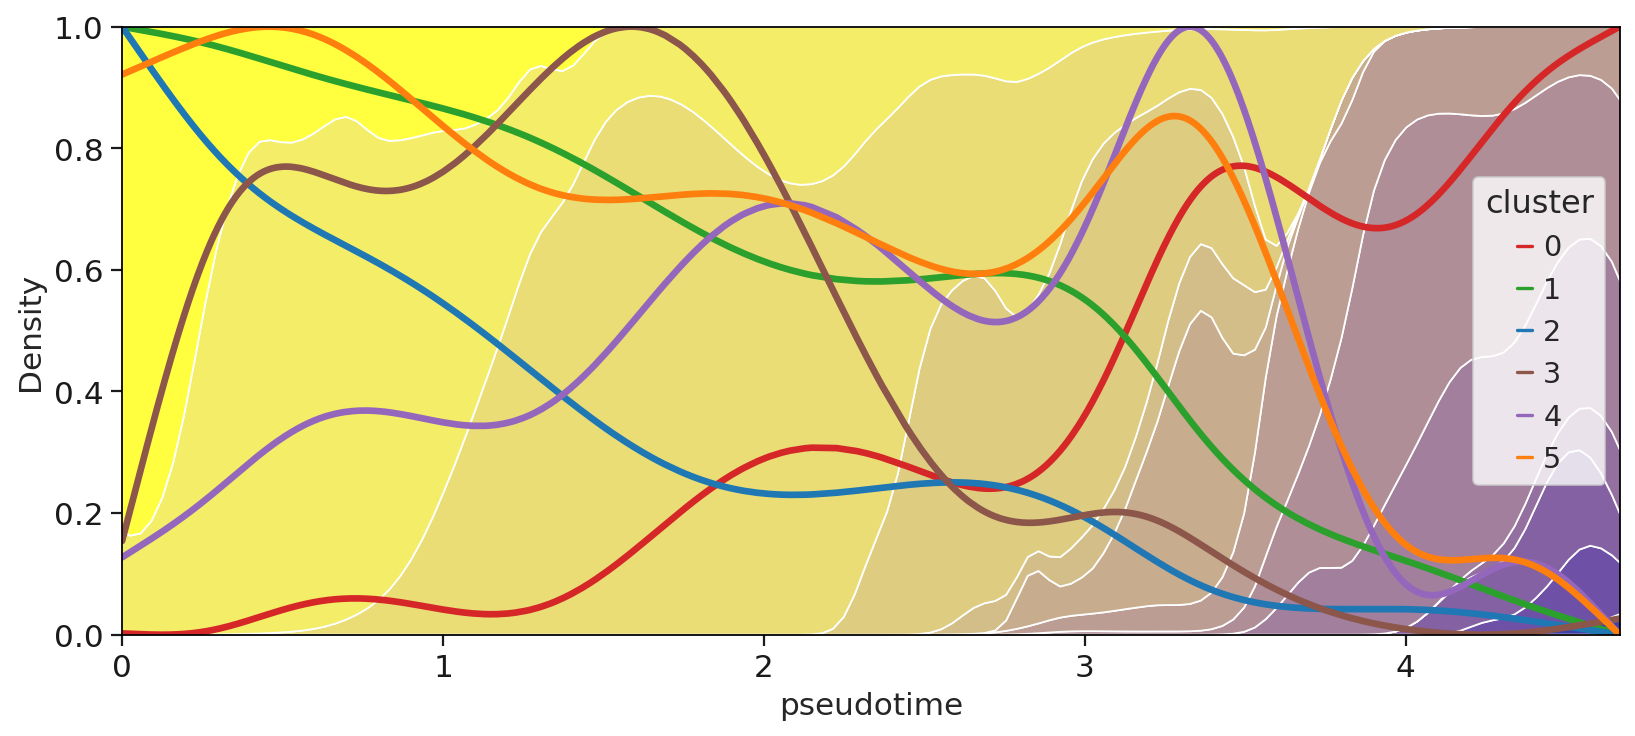

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


sc.set_figure_params(dpi_save=600)
fig, ax1 = plt.subplots(figsize=(12,5))
sns.kdeplot(data=df, x="pseudotime", hue="devtime", multiple="fill",
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax1)
ax1.set_xlim([0,adata.obs.t.max()])
#ax1.set_ylim([0.7,1])
#ax1.set_xlim([0,2])
sns.lineplot(data=df_reg,x="pseudotime",y="activity",hue="cluster",ax=ax1,palette=dct_col,lw=3,
            legend=True)
plt.grid(b=False)
plt.savefig("figures/eptNCC->imSC_progressions.png")

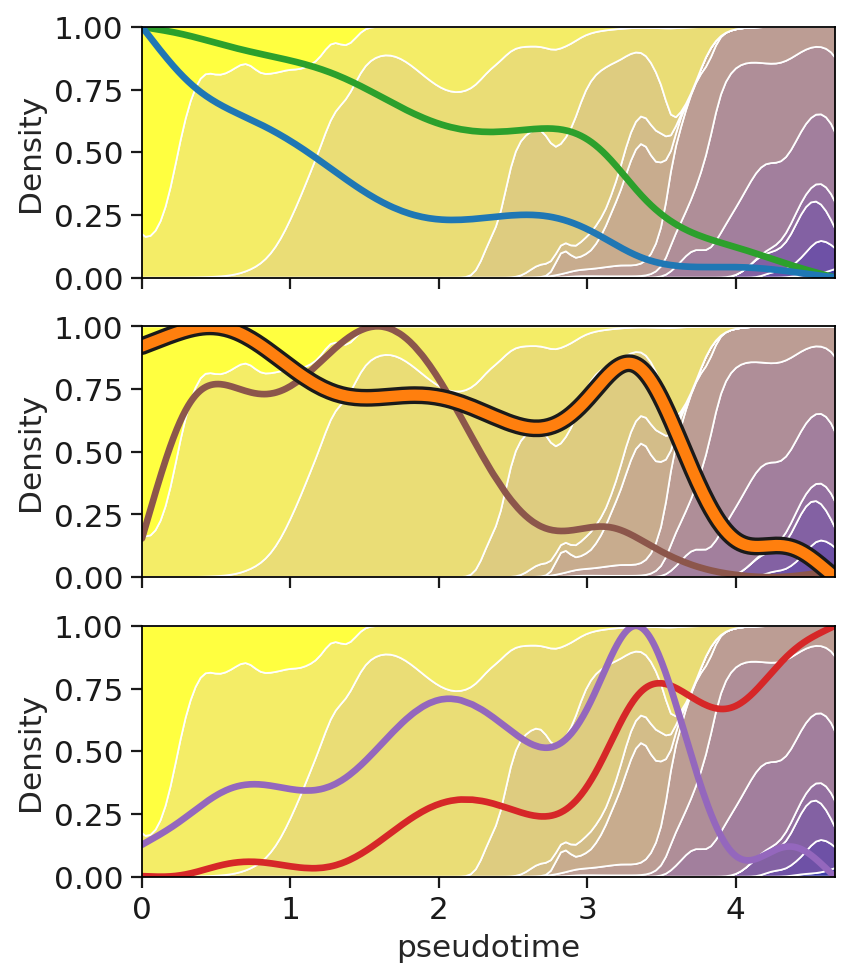

In [29]:
sc.set_figure_params(dpi_save=600)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(5.2,6),sharex=True,constrained_layout=True)

sns.kdeplot(data=df, x="pseudotime", hue="devtime", multiple="fill",
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax1)
ax1.set_xlim([0,adata.obs.t.max()])
sns.lineplot(data=df_reg.loc[df_reg.cluster.isin([1,2])],x="pseudotime",y="activity",hue="cluster",ax=ax1,palette=dct_col,lw=3,
            legend=False)
ax1.grid(b=False)



sns.kdeplot(data=df, x="pseudotime", hue="devtime", multiple="fill",
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax2)
ax2.set_xlim([0,adata.obs.t.max()])
sns.lineplot(data=df_reg.loc[df_reg.cluster.isin([3,5])],x="pseudotime",y="activity",hue="cluster",ax=ax2,palette=dct_col,lw=3,
            legend=False)
sns.lineplot(data=df_reg.loc[df_reg.cluster.isin([5])],x="pseudotime",y="activity",hue="cluster",ax=ax2,palette=["k"],lw=8,
            legend=False)
sns.lineplot(data=df_reg.loc[df_reg.cluster.isin([5])],x="pseudotime",y="activity",hue="cluster",ax=ax2,palette=dct_col,lw=5,
            legend=False)
ax2.grid(b=False)



sns.kdeplot(data=df, x="pseudotime", hue="devtime", multiple="fill",
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax3)
ax3.set_xlim([0,adata.obs.t.max()])
sns.lineplot(data=df_reg.loc[df_reg.cluster.isin([0,4])],x="pseudotime",y="activity",hue="cluster",ax=ax3,palette=dct_col,lw=3,
            legend=False)
ax3.grid(b=False)
#plt.tight_layout()

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig("figures/eptNCC->imSC_progressions_all.png")

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import patches
from adjustText import adjust_text
import math

def plot_corr(corrs,loc_down="lower center",title = "feature"):

    fig, ax = plt.subplots(figsize=(2.5,2.2))

    ax.fill_between(range(len(corrs)), 0, corrs, where=corrs >= 0,color="tab:blue")
    ax.fill_between(range(len(corrs)), 0, corrs, where=corrs <= 0,color="tab:red")
    ax.scatter(range(len(corrs)),corrs,c="k",s=2)
    ax.grid(b=False)
    maxval=math.ceil(corrs.abs().max()*10)/10
    ax.set_ylim([-maxval,maxval])
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position(('axes', 0.5))
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_ylabel("pearson correlation\n with "+title,fontsize=11)
    ax.yaxis.set_tick_params(width=2)
    ax.set_yticks([0])

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)




    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    ax3 = inset_axes(ax,bbox_to_anchor=(1.05, 1),bbox_transform=ax.transAxes,
                        width=1.3, # width = 30% of parent_bbox
                        height=1.3, # height : 1 inch
                        loc=loc_down)
    xs=range(1,11)
    ys=corrs[-10:]
    ls=corrs[-10:].index

    ax3.scatter(xs,ys,c="k",s=10)
    ax3.grid(b=False)
    ax3.set_xticks([])
    ax3.set_yticks([])
    texts = []
    for x, y, l in zip(xs, ys,ls):
        if l == "Six1(+)" :
            texts.append(ax3.text(x, y, l, size=9,color='r'))
        else:
            texts.append(ax3.text(x, y, l, size=9))
    
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5), expand_text=(1.05, 1.05))
    
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax3.tick_params(axis='both', which='major', labelsize=12)


In [17]:
sel=adata.obs_names[(adata.obs.t<2.9).values]
auc=pd.DataFrame(adata[sel].X,index=sel,columns=adata.var_names)
from scipy.stats import pearsonr
fea=adata[sel,"Ets1(+)"].X.flatten()
corrs=auc.apply(lambda x: pearsonr(x,fea)[0],axis=0)
corrs=corrs.sort_values(ascending=False)
corrs.dropna(inplace=True)
c=corrs[1:]

In [1]:
corrs

NameError: name 'corrs' is not defined

In [18]:
pvals=auc.apply(lambda x: pearsonr(x,fea)[1],axis=0)

In [19]:
pvals[corrs.index]

Bclaf1(+)    4.372795e-75
Hmga2(+)     4.079676e-74
Mycn(+)      1.317709e-64
E2f3(+)      4.443463e-62
Arid3a(+)    7.256670e-61
                 ...     
Nr2f1(+)     2.256268e-68
Cux1(+)      7.399959e-71
Nfib(+)      1.121053e-71
Bcl11a(+)    1.908712e-82
Nfia(+)      6.848338e-92
Length: 190, dtype: float64

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


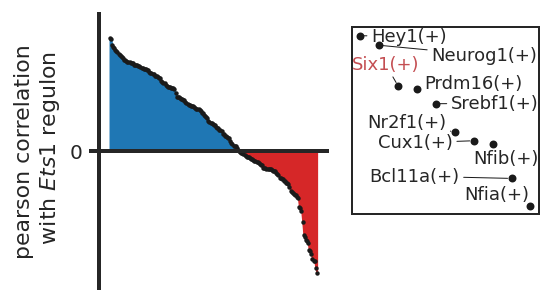

In [88]:
plot_corr(corrs,2,title="$\it{Ets1}$ regulon")
plt.tight_layout()
plt.savefig("figures/Ets1_corr.png",bbox_inches="tight",dpi=600)

In [5]:
adata.uns["graph"]=adata.uns["tree"]

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


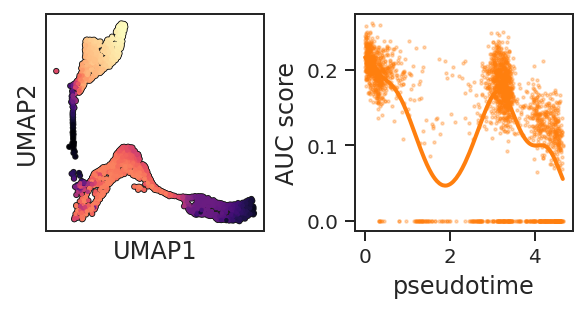

In [11]:
ax1, ax2 = scf.pl.single_trend(adata,"Ets1(+)",show_title=False,highlight=True,colorexp=dct_col[5],colormap="magma",size_cells=5,figsize=(4,2),show=False)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylabel("UMAP2",fontsize=12)
ax1.set_xlabel("UMAP1",fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylabel("AUC score",fontsize=12)
ax2.set_xlabel("pseudotime",fontsize=12)
plt.tight_layout(False)
plt.savefig("figures/Ets1.png",dpi=600)

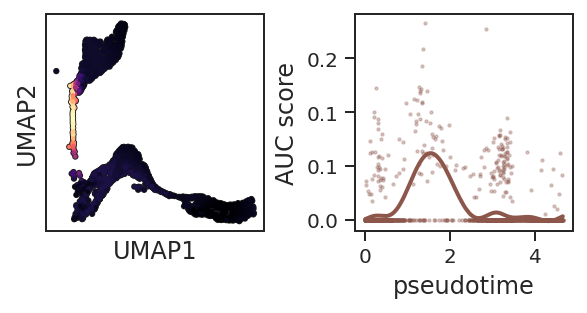

In [14]:
from matplotlib.ticker import FormatStrFormatter
ax1, ax2 = scf.pl.single_trend(adata,"Six1(+)",show_title=False,highlight=True,colorexp=dct_col[3],colormap="magma",size_cells=5,figsize=(4,2),show=False)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylabel("UMAP2",fontsize=12)
ax1.set_xlabel("UMAP1",fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylabel("AUC score",fontsize=12)
ax2.set_xlabel("pseudotime",fontsize=12)
plt.tight_layout(False)
plt.savefig("figures/Six.png",dpi=600)

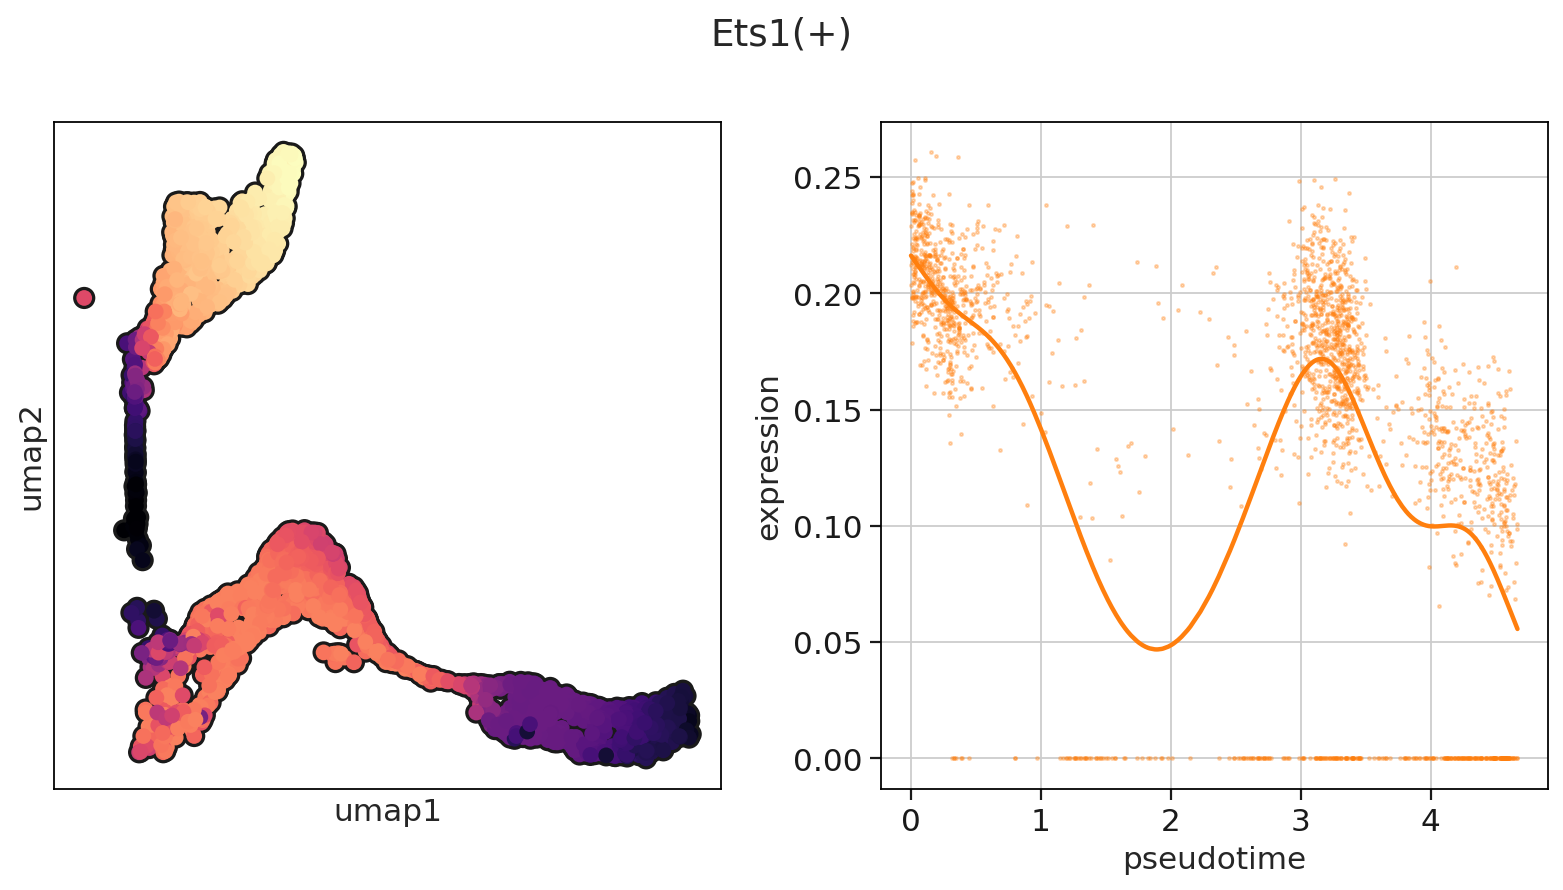

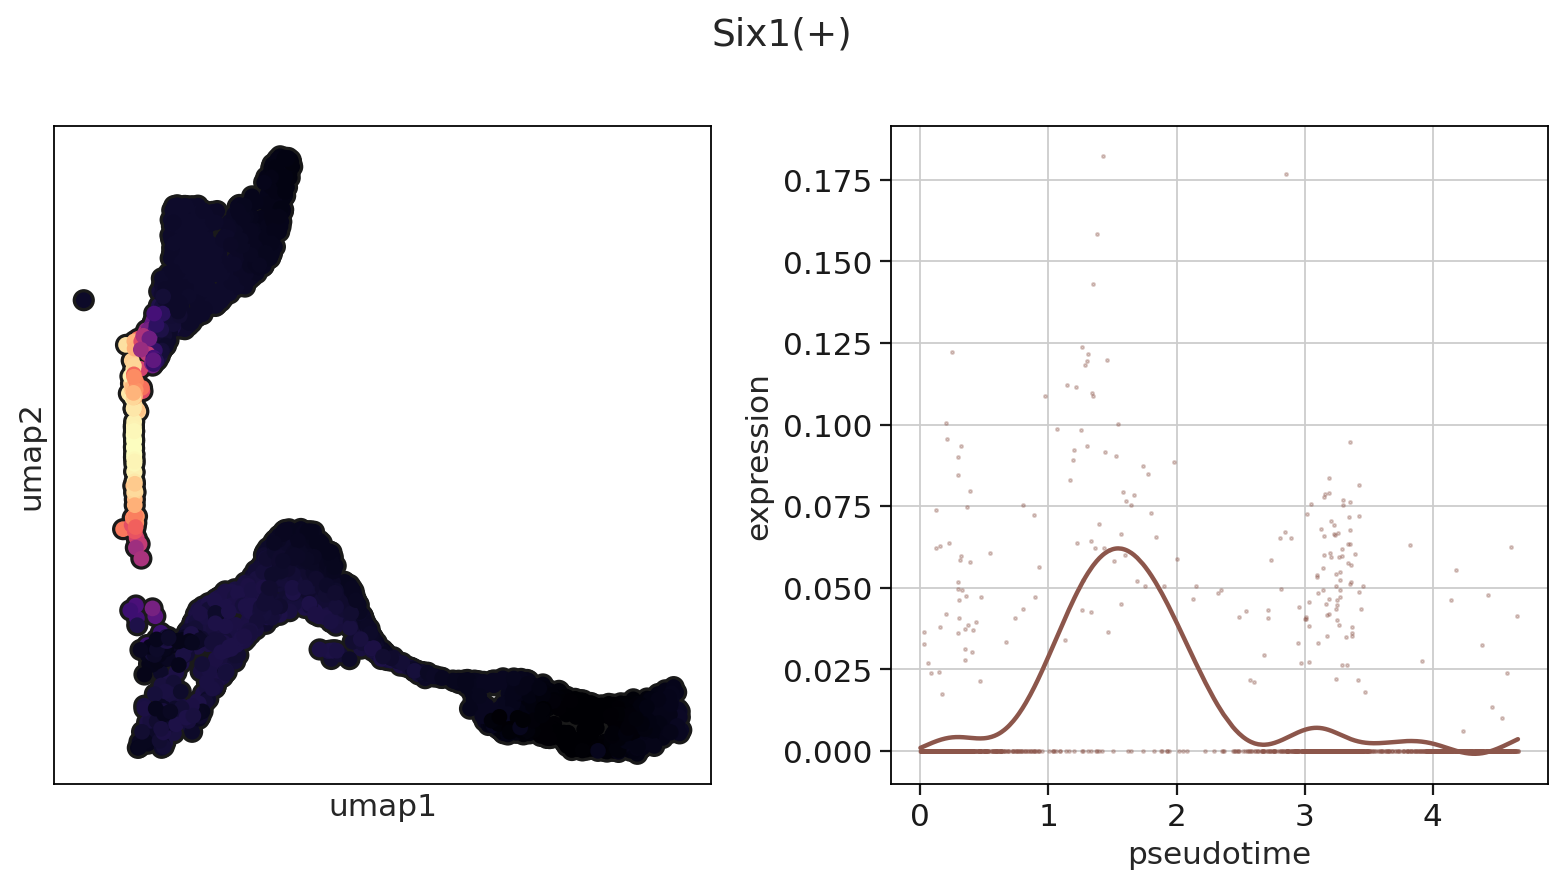

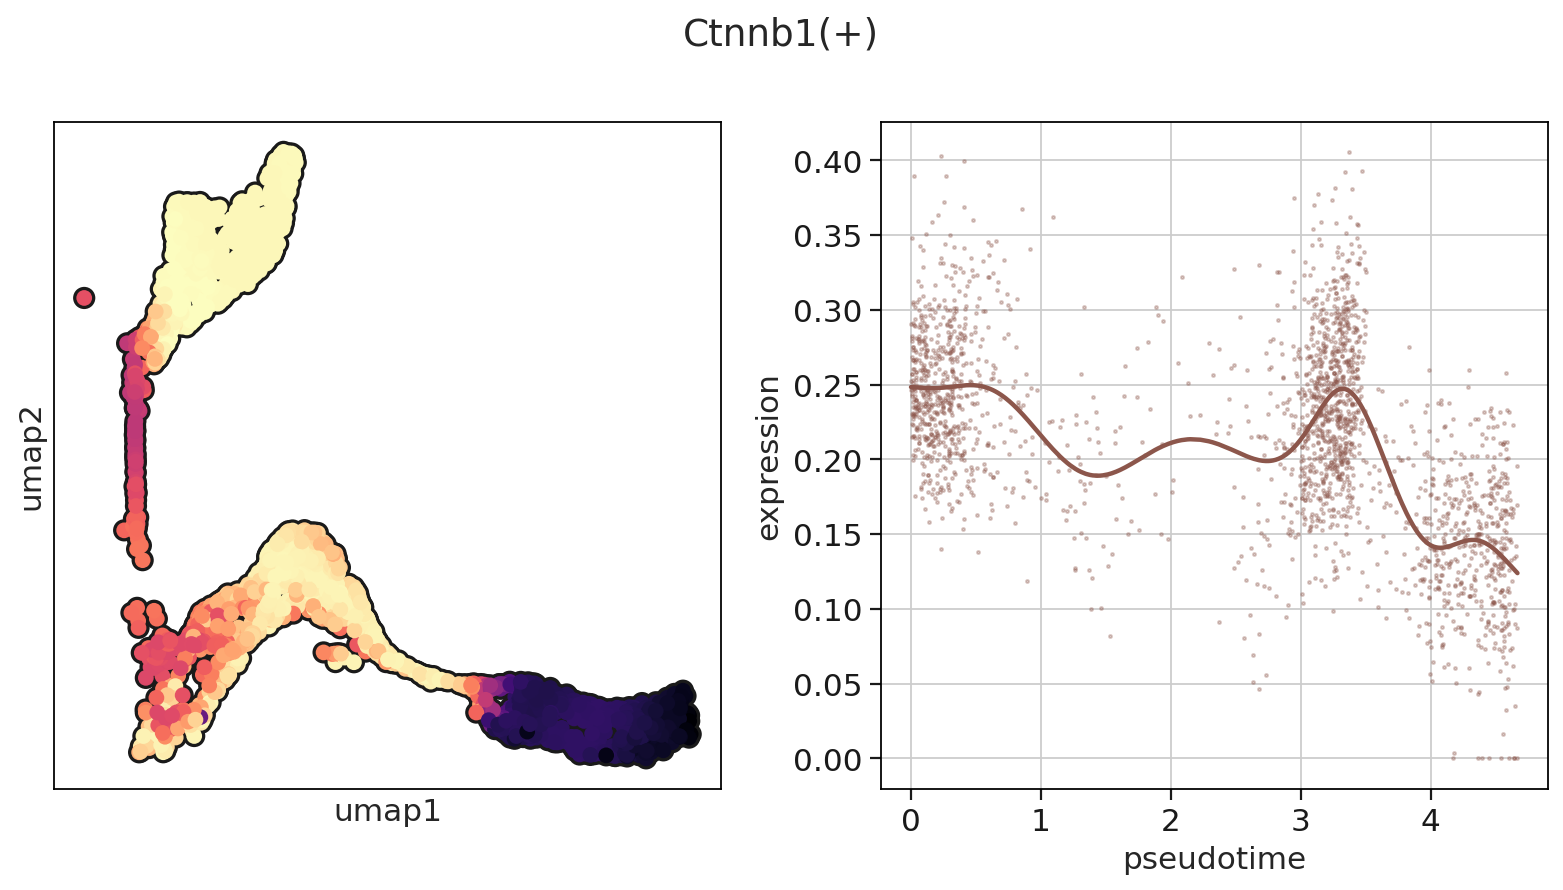

In [62]:
scf.pl.single_trend(adata,"Ets1(+)",highlight=True,colorexp=dct_col[5],colormap="magma",size_cells=5,figsize=(4,2))
scf.pl.single_trend(adata,"Six1(+)",highlight=True,colorexp=dct_col[3],colormap="magma",size_cells=50)
scf.pl.single_trend(adata,"Ctnnb1(+)",highlight=True,colorexp=dct_col[3],colormap="magma",size_cells=50)

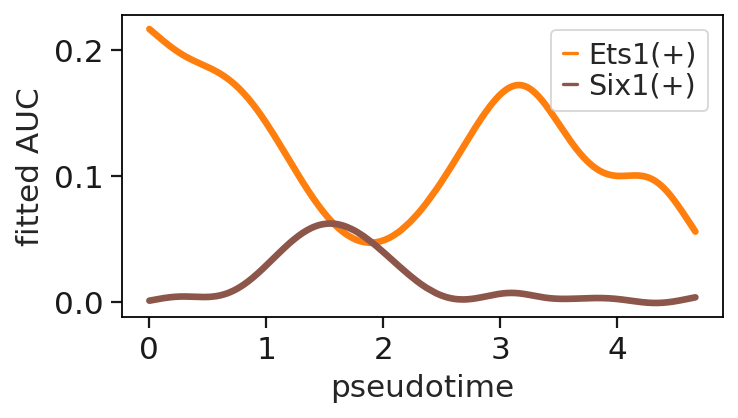

In [54]:
# https://scholarcommons.sc.edu/cgi/viewcontent.cgi?article=5306&context=etd 
# pdf page 98  manuscript page 80
l=list(map(lambda g: pd.DataFrame({"t":adata.obs.t,
              "fitted":adata[:,g].layers["fitted"].flatten(),
              "expr":adata[:,g].X.flatten(),
             "regulon":g}),["Ets1(+)","Six1(+)"]))

l=pd.concat(l)

import seaborn as sns
fig, ax = plt.subplots(figsize=(4.5,2.5),constrained_layout=True)
sns.lineplot(data=l,x="t",y="fitted",hue="regulon",linewidth=3,palette=[dct_col[5],dct_col[3]],ax=ax)
ax.grid(b=False)
ax.set_xlabel("pseudotime")
ax.set_ylabel("fitted AUC")
ax.legend(labelspacing=0.1)
plt.savefig("figures/Ets1_Six1.png",dpi=600)

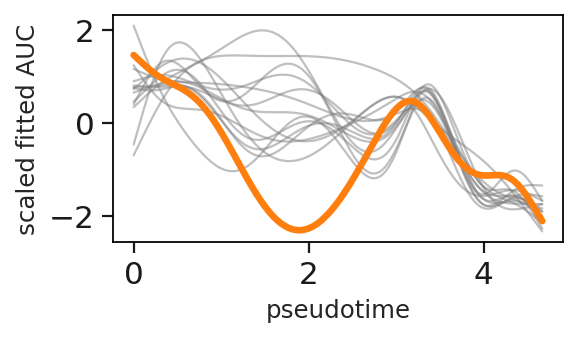

In [66]:
from sklearn.preprocessing import scale
l=list(map(lambda g: pd.DataFrame({"t":adata.obs.t,
              "fitted":scale(adata[:,g].layers["fitted"].flatten()),
              "expr":scale(adata[:,g].X.flatten()),
             "regulon":g}),adata.var_names[adata.var.fit_clusters==5]))

l=pd.concat(l)

import seaborn as sns
fig, ax = plt.subplots(figsize=(3.5,2),constrained_layout=True)
for g in adata.var_names[adata.var.fit_clusters==5]:
    l=pd.DataFrame({"t":adata.obs.t,
              "fitted":scale(adata[:,g].layers["fitted"].flatten()),
              "expr":scale(adata[:,g].X.flatten()),
             "regulon":g})
    sns.lineplot(data=l,x="t",y="fitted",color="grey",alpha=.5,linewidth=1,ax=ax,legend=False)
    ax.grid(b=False)
l=list(map(lambda g: pd.DataFrame({"t":adata.obs.t,
              "fitted":scale(adata[:,g].layers["fitted"].flatten()),
              "expr":adata[:,g].X.flatten(),
             "regulon":g}),["Ets1(+)"]))

l=pd.concat(l)
sns.lineplot(data=l,x="t",y="fitted",hue="regulon",linewidth=3,palette=[dct_col[5]],
             legend=False,ax=ax,style="regulon")
ax.set_xlabel("pseudotime",fontsize=11)
ax.set_ylabel("scaled fitted AUC",fontsize=11)
plt.savefig("figures/Ets1_inregulon.png",dpi=600)

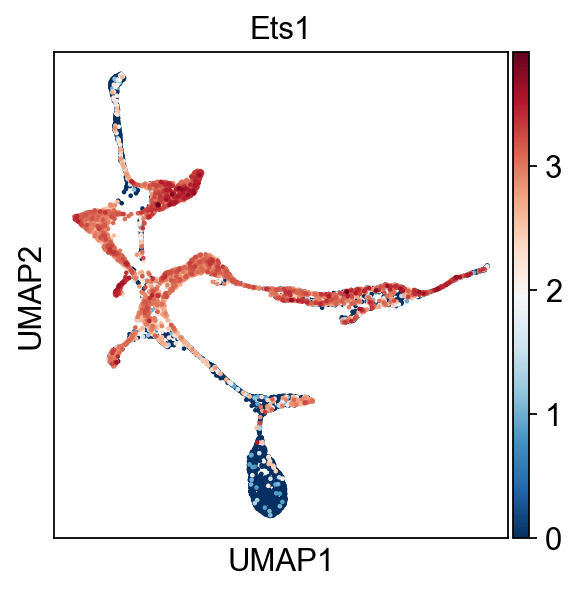

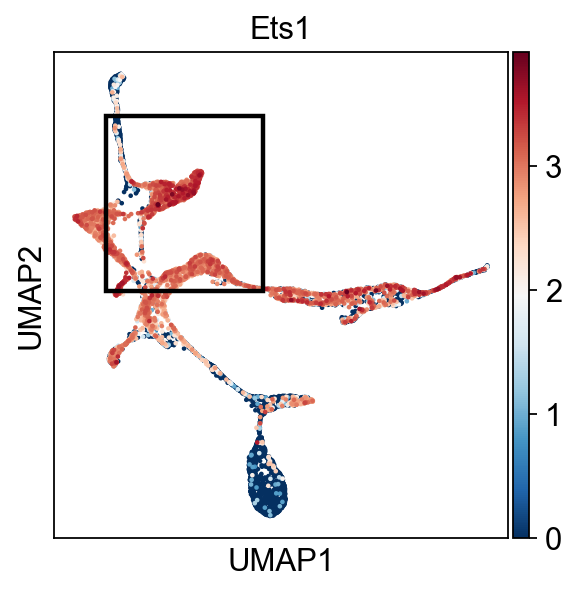

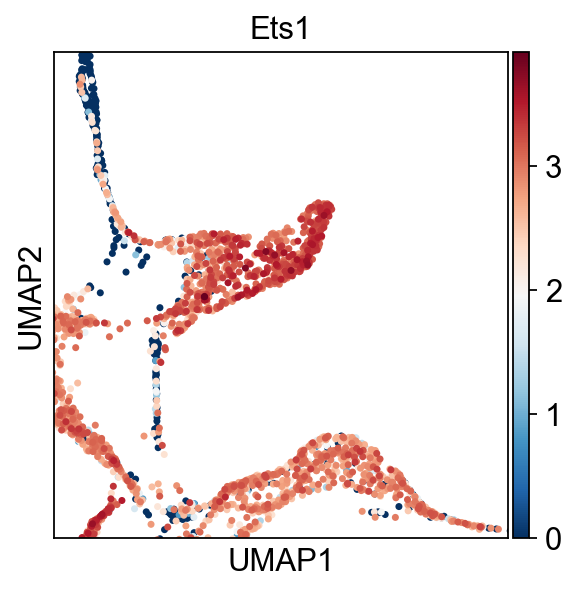

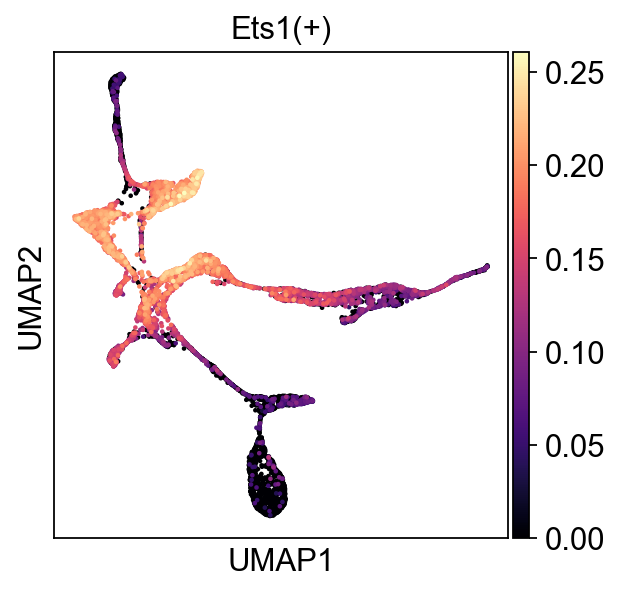

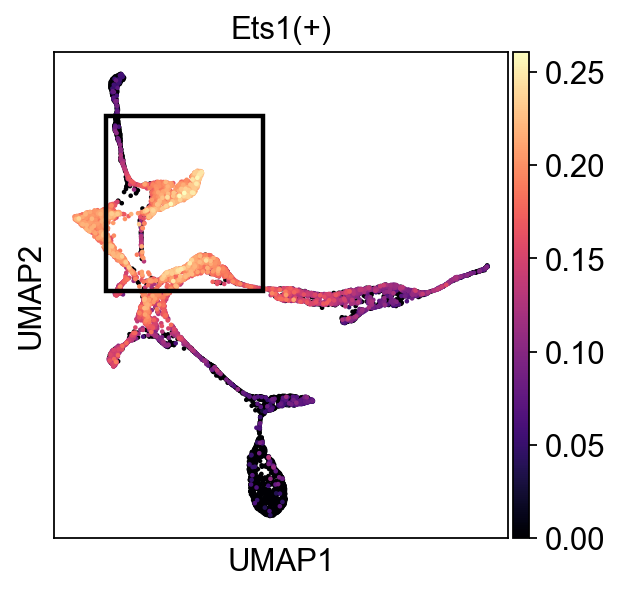

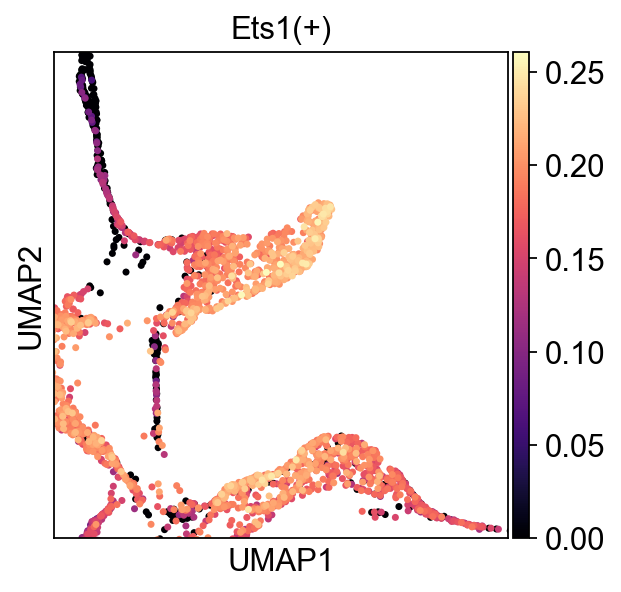

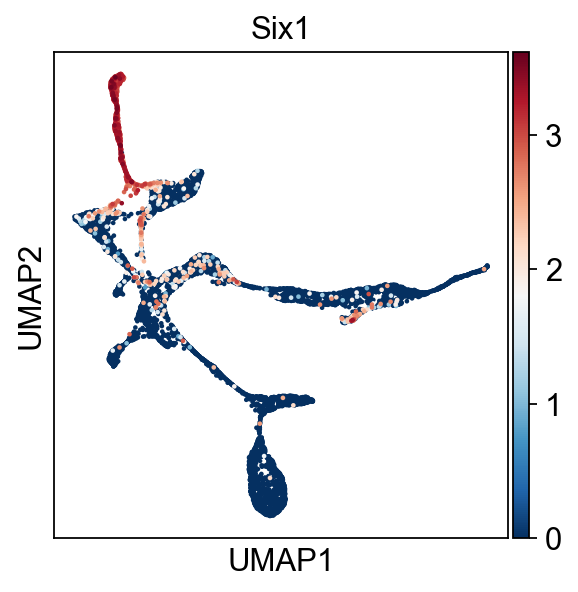

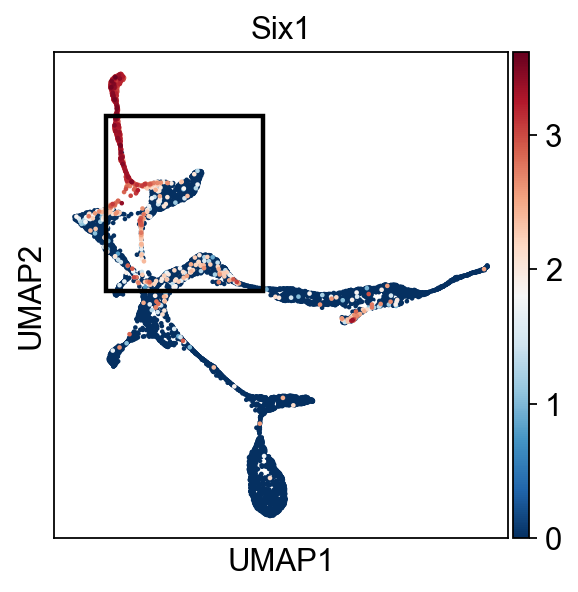

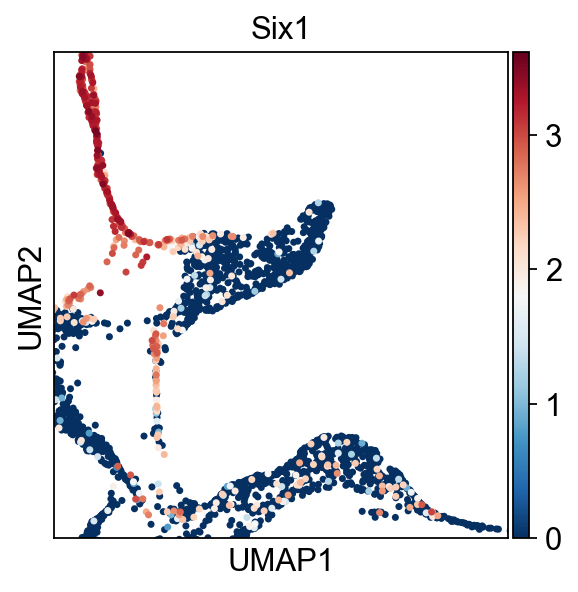

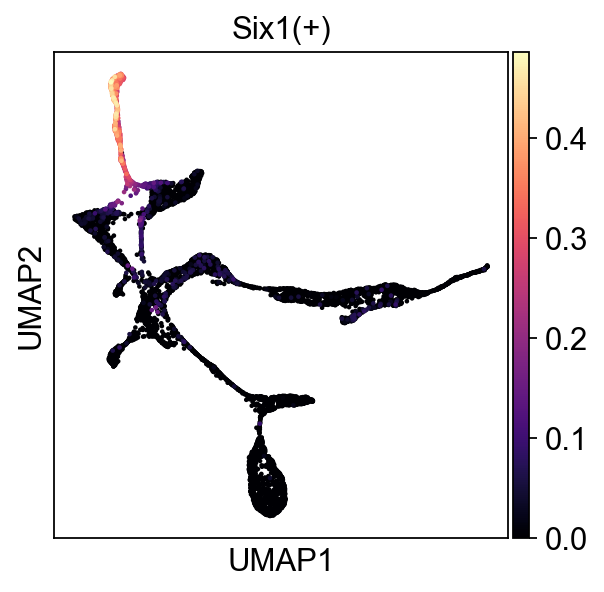

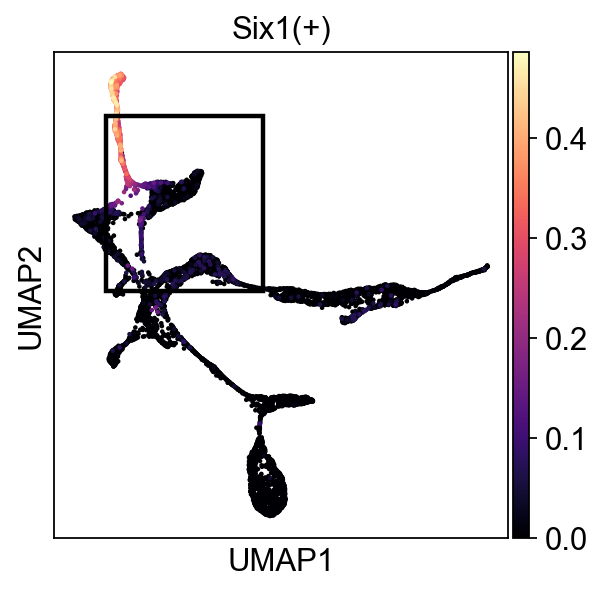

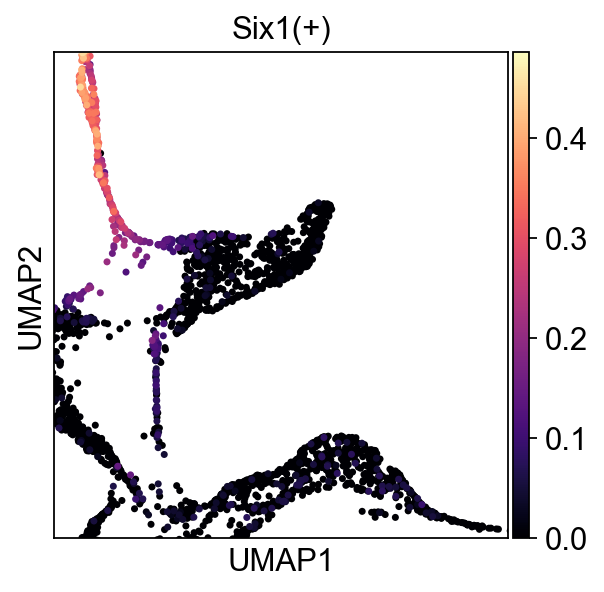

In [21]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

import scanpy as sc
sc.set_figure_params(dpi_save=600)

for g in ["Ets1","Six1"]:
    adata_all=sc.read("adata_tree_fpm.h5ad")
    sc.pl.umap(adata_all,color=g,cmap="RdBu_r",save="_"+g+".svg")
    ax=sc.pl.umap(adata_all,color=g,cmap="RdBu_r",show=False)
    rect = patches.Rectangle((-13,2),15,16,linewidth=2,edgecolor='k',facecolor='none')
    ax.add_patch(rect)
    plt.savefig('figures/'+g+'_rectangle.svg',dpi=600)
    ax=sc.pl.umap(adata_all,color=g,cmap="RdBu_r",show=False,size=40)
    plt.xlim([-13,2])
    plt.ylim([2,18])
    plt.savefig('figures/'+g+'_zoom.svg',dpi=600)

    adata_all=sc.read("adata_tree_auc.h5ad")
    sc.pl.umap(adata_all,color=g+"(+)",cmap="magma",save="_"+g+"(+).svg")
    ax=sc.pl.umap(adata_all,color=g+"(+)",cmap="magma",show=False)
    rect = patches.Rectangle((-13,2),15,16,linewidth=2,edgecolor='k',facecolor='none')
    ax.add_patch(rect)
    plt.savefig('figures/'+g+'(+)_rectangle.svg',dpi=600)
    ax=sc.pl.umap(adata_all,color=g+"(+)",cmap="magma",show=False,size=40)
    plt.xlim([-13,2])
    plt.ylim([2,18])
    plt.savefig('figures/'+g+'(+)_zoom.svg',dpi=600)

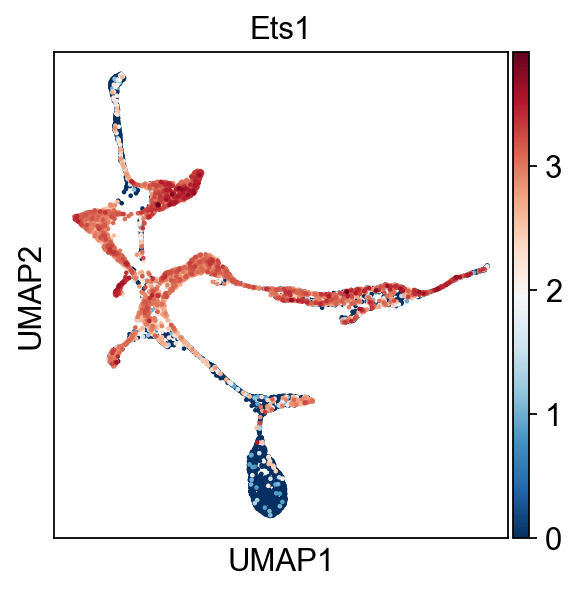

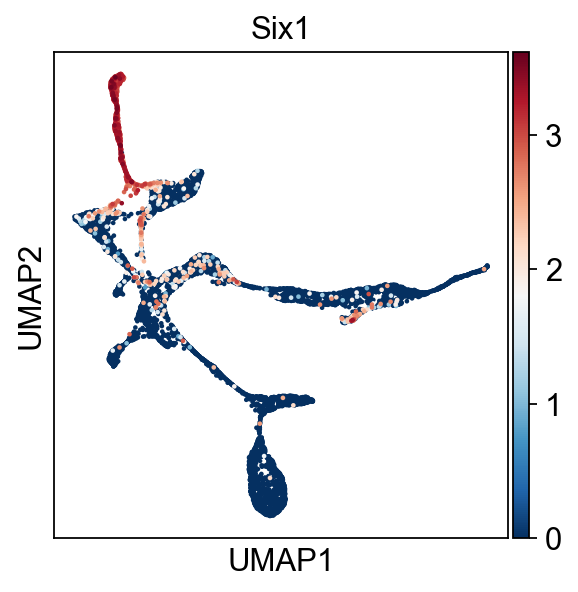

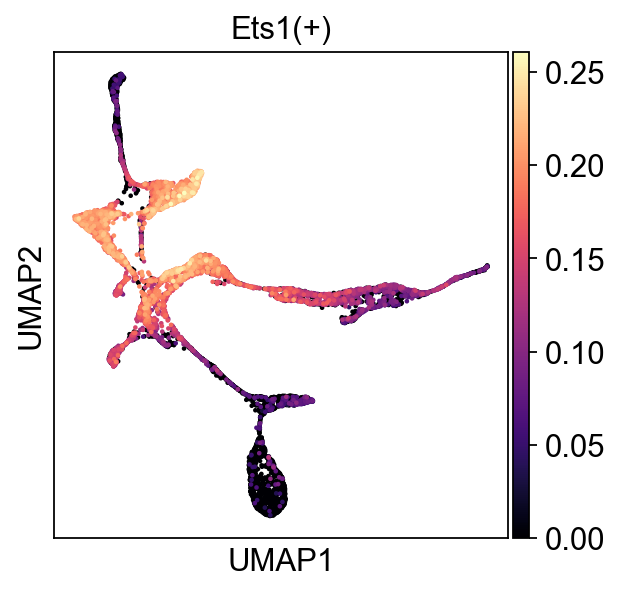

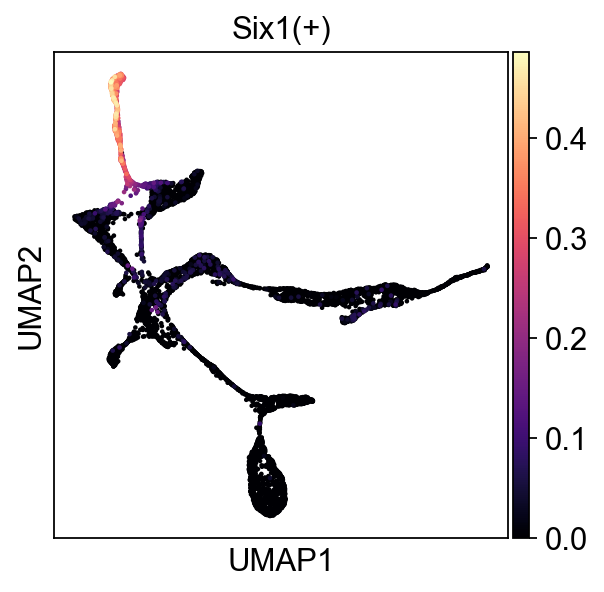

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import scanpy as sc
sc.set_figure_params(dpi_save=600)

adata_all=sc.read("adata_tree_fpm.h5ad")
sc.pl.umap(adata_all,color="Ets1",cmap="RdBu_r",save="_Ets1.png")
sc.pl.umap(adata_all,color="Six1",cmap="RdBu_r",save="_Six1.png")

adata_all=sc.read("adata_tree_auc.h5ad")
sc.pl.umap(adata_all,color="Ets1(+)",cmap="magma",save="_Ets1(+).png")
sc.pl.umap(adata_all,color="Six1(+)",cmap="magma",save="_Six1(+).png")